# Evaluation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pickle

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loss

This model has two loss functions. One for the classification subnet, the other for the bounding box regression subnet.

Plot the total, regression and classification losses with validation and save figs.

In [2]:
def plot_loss_history(history_path):
    with (open(history_path, 'rb')) as file:
        history = pickle.load(file)
    
    # get the history file name for savefig
    title, _ = os.path.splitext(history_path)
    
    # validation losses
    val_loss = history['val_loss']
    val_regression_loss = history['val_regression_loss']
    val_classification_loss = history['val_classification_loss']

    # training losses
    loss = history['loss']
    regression_loss = history['regression_loss']
    classification_loss = history['classification_loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.savefig('./history/' + title + '_loss.png')
    plt.show()

    plt.title('Classification Loss')
    plt.plot(val_classification_loss, 'r', regression_loss, 'b')
    plt.savefig('./history/' + title + '_cl_loss.png')
    plt.show()

    plt.title('Regression Loss')
    plt.plot(val_regression_loss, 'r', regression_loss, 'b')
    plt.savefig('./history/' + title + '_reg_loss.png')
    plt.show()

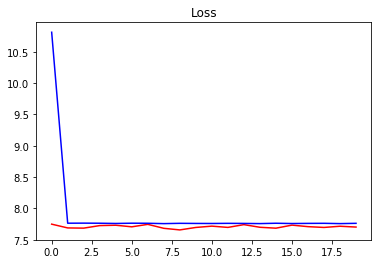

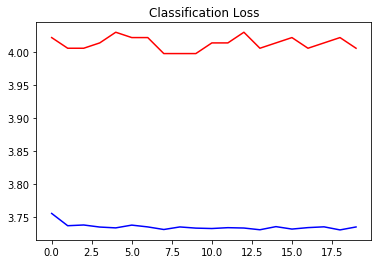

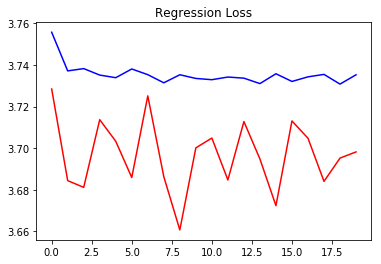

In [3]:
plot_loss_history('./history/history.pkl')

## AP/AR

This section loads the trained model and creates a submission text file for the VIVA Hand Detection Challenge evaluation kit to evaluate.

In [31]:
model = keras.models.load_model('./snapshots/resnet50_csv_22.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/home/ubuntu/.local/lib/python3.6/site-packages/Keras-2.1.2-py3.6.egg/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [32]:
test_generator = keras.preprocessing.image.ImageDataGenerator()
csv_test_generator = CSVGenerator(
    './data/test.csv',
    './data/classes.csv',
    test_generator,
    batch_size=1,
)

In [33]:
def get_detections_for_image(image, model, generator):
    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    detections[0, :, :4] /= scale
    
    return detections

Test prediction on a random image.

processing time:  0.7820923328399658


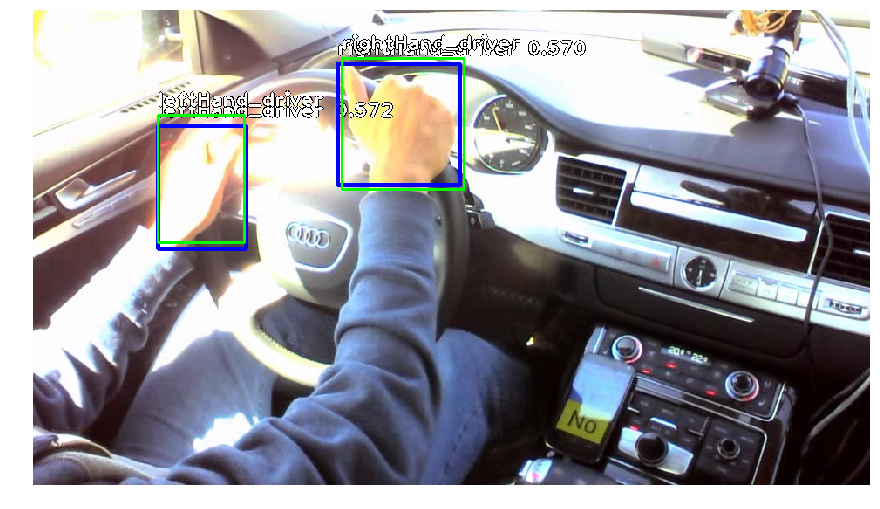

In [34]:
from random import randint

test_index = randint(0,csv_test_generator.size())
# load image
image = csv_test_generator.load_image(test_index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
detections = get_detections_for_image(image, model, csv_test_generator)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(csv_test_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

annotations = csv_test_generator.load_annotations(test_index)

# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(csv_test_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.savefig('detection.png')
plt.imshow(draw)
plt.show()

A single detection example:

In [35]:
print(detections[0,100,:])
plt.savefig('detection.png')

[  5.61473694e+02   9.30549049e+00   1.22641272e+03   3.52091370e+02
   2.45853816e-03   2.32758746e-03   1.96317746e-03   2.32707267e-03]


In [36]:
entries = []

for index in range(csv_test_generator.size()):
    # load image
    image = csv_test_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)
    annotations = csv_test_generator.load_annotations(index)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.25:
            continue
        _, filename = os.path.split(csv_test_generator.image_path(index))
        filename, _ = os.path.splitext(filename)
        
        b = detections[0, idx, :4].astype(int)
        
        if b[0] < b[2]:
            x, y, w, h = float(b[0]), float(b[1]), float(b[2]-b[0]), float(b[3]-b[1])
        else:
            x, y, w, h = float(b[1]), float(b[0]), float(b[0]-b[2]), float(b[1]-b[3])
            
        entry = '{} {} {} {} {} {} -1 -1 -1'.format(filename, x, y, w, h, score)
        print(entry)
        entries.append(entry)

print('Found {} entries.'.format(len(entries)))
submission = '\n'.join(entries)
with open('submission.txt', 'w') as file:
    file.write(submission)

processing time:  0.22460699081420898
10L_0015700_Q_1_4_5 473.0 354.0 78.0 69.0 0.47838154435157776 -1 -1 -1
10L_0015700_Q_1_4_5 203.0 260.0 91.0 78.0 0.38764411211013794 -1 -1 -1
processing time:  0.20111298561096191
10L_0015701_Q_1_4_5 474.0 354.0 77.0 69.0 0.46510785818099976 -1 -1 -1
10L_0015701_Q_1_4_5 204.0 260.0 90.0 78.0 0.3905973732471466 -1 -1 -1
processing time:  0.18911242485046387
10L_0015702_Q_1_4_5 473.0 354.0 78.0 69.0 0.4693417549133301 -1 -1 -1
10L_0015702_Q_1_4_5 203.0 259.0 91.0 79.0 0.42237502336502075 -1 -1 -1
processing time:  0.18655180931091309
10L_0015703_Q_1_4_5 474.0 354.0 77.0 69.0 0.43761205673217773 -1 -1 -1
10L_0015703_Q_1_4_5 203.0 260.0 92.0 78.0 0.3989783823490143 -1 -1 -1
processing time:  0.1881716251373291
10L_0015704_Q_1_4_5 473.0 354.0 77.0 69.0 0.43761250376701355 -1 -1 -1
10L_0015704_Q_1_4_5 202.0 259.0 93.0 79.0 0.39910000562667847 -1 -1 -1
processing time:  0.18352150917053223
10L_0015705_Q_1_4_5 473.0 354.0 77.0 69.0 0.4389304220676422 -1 -1

processing time:  0.18907642364501953
10L_0015754_Q_1_4_5 223.0 265.0 83.0 85.0 0.5799914002418518 -1 -1 -1
10L_0015754_Q_1_4_5 473.0 353.0 77.0 71.0 0.4893621504306793 -1 -1 -1
processing time:  0.18459081649780273
10L_0015755_Q_1_4_5 224.0 266.0 82.0 83.0 0.5796374082565308 -1 -1 -1
10L_0015755_Q_1_4_5 473.0 353.0 78.0 71.0 0.49441587924957275 -1 -1 -1
processing time:  0.1808476448059082
10L_0015756_Q_1_4_5 224.0 266.0 82.0 83.0 0.5581367015838623 -1 -1 -1
10L_0015756_Q_1_4_5 473.0 353.0 77.0 71.0 0.4761058986186981 -1 -1 -1
processing time:  0.18469595909118652
10L_0015757_Q_1_4_5 227.0 265.0 77.0 84.0 0.4999580383300781 -1 -1 -1
10L_0015757_Q_1_4_5 473.0 353.0 77.0 70.0 0.49581238627433777 -1 -1 -1
processing time:  0.18823862075805664
10L_0015758_Q_1_4_5 474.0 354.0 78.0 69.0 0.4995443820953369 -1 -1 -1
10L_0015758_Q_1_4_5 227.0 266.0 76.0 82.0 0.476705938577652 -1 -1 -1
processing time:  0.18712854385375977
10L_0015759_Q_1_4_5 226.0 266.0 77.0 82.0 0.5231265425682068 -1 -1 -1
10

processing time:  0.18518877029418945
10L_0015806_Q_1_4_5 247.0 275.0 69.0 85.0 0.5792096853256226 -1 -1 -1
10L_0015806_Q_1_4_5 474.0 355.0 78.0 69.0 0.5034794211387634 -1 -1 -1
10L_0015806_Q_1_4_5 105.0 277.0 87.0 57.0 0.4097823202610016 -1 -1 -1
processing time:  0.18370580673217773
10L_0015808_Q_1_4_5 473.0 353.0 77.0 71.0 0.4829312264919281 -1 -1 -1
10L_0015808_Q_1_4_5 259.0 284.0 60.0 78.0 0.4641251862049103 -1 -1 -1
10L_0015808_Q_1_4_5 136.0 285.0 67.0 55.0 0.2808213531970978 -1 -1 -1
processing time:  0.1871185302734375
10L_0015809_Q_1_4_5 264.0 288.0 59.0 74.0 0.5143060684204102 -1 -1 -1
10L_0015809_Q_1_4_5 473.0 354.0 78.0 70.0 0.4897920787334442 -1 -1 -1
processing time:  0.18833160400390625
10L_0015812_Q_1_4_5 275.0 298.0 54.0 63.0 0.553004264831543 -1 -1 -1
10L_0015812_Q_1_4_5 474.0 353.0 76.0 70.0 0.501029372215271 -1 -1 -1
10L_0015812_Q_1_4_5 190.0 308.0 53.0 85.0 0.34995976090431213 -1 -1 -1
processing time:  0.192643404006958
10L_0015813_Q_1_4_5 474.0 353.0 76.0 70.0 0.

processing time:  0.1834094524383545
10L_0015851_Q_1_4_5 473.0 353.0 77.0 70.0 0.42783287167549133 -1 -1 -1
10L_0015851_Q_1_4_5 190.0 307.0 55.0 88.0 0.42516839504241943 -1 -1 -1
processing time:  0.1839139461517334
10L_0015852_Q_1_4_5 190.0 307.0 55.0 88.0 0.43967440724372864 -1 -1 -1
10L_0015852_Q_1_4_5 472.0 353.0 78.0 71.0 0.4086095988750458 -1 -1 -1
10L_0015852_Q_1_4_5 370.0 310.0 76.0 84.0 0.33668771386146545 -1 -1 -1
processing time:  0.184326171875
10L_0015853_Q_1_4_5 472.0 354.0 79.0 70.0 0.4858454167842865 -1 -1 -1
10L_0015853_Q_1_4_5 191.0 310.0 52.0 83.0 0.4017414152622223 -1 -1 -1
10L_0015853_Q_1_4_5 370.0 309.0 83.0 85.0 0.3003571331501007 -1 -1 -1
processing time:  0.18413424491882324
10L_0015854_Q_1_4_5 473.0 354.0 78.0 70.0 0.4551389515399933 -1 -1 -1
10L_0015854_Q_1_4_5 191.0 310.0 52.0 83.0 0.39437437057495117 -1 -1 -1
processing time:  0.18376946449279785
10L_0015855_Q_1_4_5 473.0 354.0 78.0 70.0 0.453610360622406 -1 -1 -1
10L_0015855_Q_1_4_5 191.0 310.0 52.0 83.0 0

processing time:  0.18217086791992188
10L_0015889_Q_1_4_5 473.0 354.0 77.0 69.0 0.5072392225265503 -1 -1 -1
10L_0015889_Q_1_4_5 191.0 307.0 55.0 89.0 0.4407520592212677 -1 -1 -1
10L_0015889_Q_1_4_5 365.0 316.0 55.0 76.0 0.2956677973270416 -1 -1 -1
processing time:  0.18621325492858887
10L_0015891_Q_1_4_5 472.0 354.0 78.0 70.0 0.4895176887512207 -1 -1 -1
10L_0015891_Q_1_4_5 191.0 307.0 54.0 88.0 0.43192824721336365 -1 -1 -1
10L_0015891_Q_1_4_5 364.0 320.0 54.0 87.0 0.3231440782546997 -1 -1 -1
processing time:  0.19064640998840332
10L_0015892_Q_1_4_5 472.0 354.0 78.0 70.0 0.505911648273468 -1 -1 -1
10L_0015892_Q_1_4_5 191.0 307.0 54.0 88.0 0.42808499932289124 -1 -1 -1
10L_0015892_Q_1_4_5 367.0 324.0 54.0 74.0 0.33969929814338684 -1 -1 -1
processing time:  0.18856334686279297
10L_0015893_Q_1_4_5 472.0 354.0 77.0 70.0 0.510112464427948 -1 -1 -1
10L_0015893_Q_1_4_5 191.0 307.0 54.0 88.0 0.4398864507675171 -1 -1 -1
10L_0015893_Q_1_4_5 364.0 320.0 53.0 88.0 0.3540934920310974 -1 -1 -1
process

processing time:  0.18228578567504883
10L_0015927_Q_1_4_5 366.0 316.0 55.0 75.0 0.5186033248901367 -1 -1 -1
10L_0015927_Q_1_4_5 472.0 353.0 78.0 70.0 0.4845712184906006 -1 -1 -1
10L_0015927_Q_1_4_5 191.0 308.0 55.0 87.0 0.4239015579223633 -1 -1 -1
processing time:  0.18530774116516113
10L_0015928_Q_1_4_5 473.0 353.0 77.0 70.0 0.4743873178958893 -1 -1 -1
10L_0015928_Q_1_4_5 191.0 308.0 55.0 88.0 0.4582836925983429 -1 -1 -1
10L_0015928_Q_1_4_5 345.0 304.0 55.0 86.0 0.42000171542167664 -1 -1 -1
processing time:  0.18637633323669434
10L_0015929_Q_1_4_5 472.0 353.0 78.0 70.0 0.4728188216686249 -1 -1 -1
10L_0015929_Q_1_4_5 191.0 308.0 54.0 87.0 0.4644942283630371 -1 -1 -1
10L_0015929_Q_1_4_5 335.0 302.0 59.0 79.0 0.30203789472579956 -1 -1 -1
processing time:  0.18507766723632812
10L_0015930_Q_1_4_5 320.0 297.0 58.0 77.0 0.6212763786315918 -1 -1 -1
10L_0015930_Q_1_4_5 473.0 353.0 77.0 70.0 0.47904762625694275 -1 -1 -1
10L_0015930_Q_1_4_5 191.0 307.0 54.0 88.0 0.4421314299106598 -1 -1 -1
proce

processing time:  0.18176746368408203
10L_0015995_Q_1_4_5 280.0 295.0 61.0 73.0 0.5991042852401733 -1 -1 -1
10L_0015995_Q_1_4_5 473.0 354.0 77.0 70.0 0.41330981254577637 -1 -1 -1
10L_0015995_Q_1_4_5 194.0 308.0 47.0 77.0 0.2960849702358246 -1 -1 -1
processing time:  0.1847538948059082
10L_0016059_Q_1_4_5 253.0 228.0 82.0 111.0 0.4992499351501465 -1 -1 -1
10L_0016059_Q_1_4_5 473.0 354.0 77.0 70.0 0.4279308319091797 -1 -1 -1
10L_0016059_Q_1_4_5 191.0 307.0 55.0 93.0 0.29609301686286926 -1 -1 -1
processing time:  0.18715524673461914
10L_0016061_Q_1_4_5 304.0 223.0 83.0 109.0 0.455302894115448 -1 -1 -1
10L_0016061_Q_1_4_5 473.0 354.0 77.0 69.0 0.4498196840286255 -1 -1 -1
10L_0016061_Q_1_4_5 191.0 309.0 52.0 87.0 0.32680410146713257 -1 -1 -1
processing time:  0.18566489219665527
10L_0016062_Q_1_4_5 472.0 353.0 78.0 70.0 0.4751824140548706 -1 -1 -1
10L_0016062_Q_1_4_5 190.0 310.0 53.0 86.0 0.3055577874183655 -1 -1 -1
processing time:  0.18381857872009277
10L_0016064_Q_1_4_5 473.0 353.0 78.0 

processing time:  0.19153118133544922
10L_0016105_Q_1_4_5 474.0 354.0 79.0 70.0 0.5158144235610962 -1 -1 -1
processing time:  0.19037246704101562
10L_0016106_Q_1_4_5 474.0 354.0 79.0 70.0 0.4702148139476776 -1 -1 -1
processing time:  0.19314217567443848
10L_0016107_Q_1_4_5 474.0 354.0 78.0 70.0 0.47717052698135376 -1 -1 -1
processing time:  0.1941394805908203
10L_0016108_Q_1_4_5 474.0 355.0 78.0 69.0 0.46296584606170654 -1 -1 -1
processing time:  0.18880987167358398
10L_0016109_Q_1_4_5 472.0 354.0 78.0 70.0 0.4445975124835968 -1 -1 -1
processing time:  0.18274998664855957
10L_0016110_Q_1_4_5 472.0 354.0 78.0 69.0 0.4589189887046814 -1 -1 -1
processing time:  0.18513035774230957
10L_0016111_Q_1_4_5 472.0 354.0 78.0 69.0 0.45179256796836853 -1 -1 -1
processing time:  0.19052886962890625
10L_0016112_Q_1_4_5 473.0 354.0 77.0 69.0 0.42808952927589417 -1 -1 -1
10L_0016112_Q_1_4_5 198.0 256.0 104.0 97.0 0.321159690618515 -1 -1 -1
processing time:  0.18944597244262695
10L_0016114_Q_1_4_5 227.0

processing time:  0.18232107162475586
10L_0016161_Q_1_4_5 473.0 354.0 77.0 70.0 0.4546118974685669 -1 -1 -1
10L_0016161_Q_1_4_5 171.0 248.0 104.0 90.0 0.274123877286911 -1 -1 -1
processing time:  0.18491864204406738
10L_0016166_Q_1_4_5 299.0 198.0 87.0 124.0 0.49394065141677856 -1 -1 -1
10L_0016166_Q_1_4_5 473.0 353.0 76.0 70.0 0.46245765686035156 -1 -1 -1
10L_0016166_Q_1_4_5 193.0 311.0 54.0 88.0 0.29213857650756836 -1 -1 -1
processing time:  0.18507003784179688
10L_0016167_Q_1_4_5 473.0 354.0 76.0 69.0 0.43580901622772217 -1 -1 -1
processing time:  0.18317914009094238
10L_0016169_Q_1_4_5 473.0 353.0 76.0 69.0 0.422565758228302 -1 -1 -1
10L_0016169_Q_1_4_5 193.0 311.0 54.0 89.0 0.3250786364078522 -1 -1 -1
processing time:  0.18228793144226074
10L_0016170_Q_1_4_5 474.0 353.0 75.0 68.0 0.3795184791088104 -1 -1 -1
10L_0016170_Q_1_4_5 193.0 311.0 54.0 88.0 0.2909359037876129 -1 -1 -1
processing time:  0.18404579162597656
10L_0016171_Q_1_4_5 474.0 353.0 76.0 69.0 0.3801400065422058 -1 -1 -

processing time:  0.18563318252563477
10L_0016446_Q_1_4_5 474.0 354.0 77.0 70.0 0.5214782953262329 -1 -1 -1
10L_0016446_Q_1_4_5 190.0 310.0 53.0 86.0 0.3411596119403839 -1 -1 -1
10L_0016446_Q_1_4_5 355.0 242.0 82.0 107.0 0.2721555233001709 -1 -1 -1
processing time:  0.1869518756866455
10L_0016447_Q_1_4_5 474.0 354.0 76.0 69.0 0.4722585678100586 -1 -1 -1
10L_0016447_Q_1_4_5 190.0 310.0 52.0 87.0 0.36379000544548035 -1 -1 -1
processing time:  0.18792390823364258
10L_0016449_Q_1_4_5 474.0 353.0 76.0 70.0 0.4803776443004608 -1 -1 -1
10L_0016449_Q_1_4_5 191.0 308.0 51.0 88.0 0.39201176166534424 -1 -1 -1
10L_0016449_Q_1_4_5 361.0 243.0 80.0 100.0 0.3122943043708801 -1 -1 -1
processing time:  0.19164538383483887
10L_0016450_Q_1_4_5 474.0 354.0 76.0 69.0 0.4675430655479431 -1 -1 -1
10L_0016450_Q_1_4_5 191.0 309.0 52.0 87.0 0.3911629021167755 -1 -1 -1
10L_0016450_Q_1_4_5 363.0 243.0 80.0 98.0 0.2513682544231415 -1 -1 -1
processing time:  0.19284486770629883
10L_0016451_Q_1_4_5 474.0 354.0 77.0 

processing time:  0.18930792808532715
10L_0016496_Q_1_4_5 473.0 353.0 77.0 70.0 0.4362451136112213 -1 -1 -1
10L_0016496_Q_1_4_5 367.0 246.0 83.0 98.0 0.27045923471450806 -1 -1 -1
processing time:  0.19228243827819824
10L_0016497_Q_1_4_5 473.0 353.0 77.0 70.0 0.4292971193790436 -1 -1 -1
10L_0016497_Q_1_4_5 367.0 247.0 83.0 97.0 0.2771415412425995 -1 -1 -1
processing time:  0.19184470176696777
10L_0016498_Q_1_4_5 473.0 353.0 76.0 70.0 0.42570245265960693 -1 -1 -1
10L_0016498_Q_1_4_5 367.0 246.0 83.0 99.0 0.27542468905448914 -1 -1 -1
processing time:  0.18679285049438477
10L_0016499_Q_1_4_5 473.0 353.0 76.0 70.0 0.42348793148994446 -1 -1 -1
10L_0016499_Q_1_4_5 368.0 247.0 83.0 97.0 0.2700217366218567 -1 -1 -1
processing time:  0.18288278579711914
10L_0016500_Q_1_4_5 473.0 353.0 76.0 70.0 0.41394513845443726 -1 -1 -1
processing time:  0.184828519821167
10L_0016501_Q_1_4_5 472.0 353.0 78.0 71.0 0.3222258687019348 -1 -1 -1
10L_0016501_Q_1_4_5 368.0 248.0 83.0 96.0 0.27095088362693787 -1 -1 -

processing time:  0.21005773544311523
14_0000162_0_0_0_3 380.0 843.0 254.0 219.0 0.40829163789749146 -1 -1 -1
14_0000162_0_0_0_3 38.0 113.0 315.0 212.0 0.38442668318748474 -1 -1 -1
processing time:  0.2089681625366211
14_0000163_0_0_0_3 415.0 898.0 231.0 175.0 0.7179867625236511 -1 -1 -1
14_0000163_0_0_0_3 33.0 110.0 328.0 216.0 0.3785240352153778 -1 -1 -1
processing time:  0.20957493782043457
14_0000164_0_0_0_3 458.0 952.0 224.0 126.0 0.814777672290802 -1 -1 -1
14_0000164_0_0_0_3 54.0 101.0 328.0 216.0 0.35176536440849304 -1 -1 -1
processing time:  0.20952272415161133
14_0000166_0_0_0_3 468.0 963.0 219.0 117.0 0.7526950836181641 -1 -1 -1
14_0000166_0_0_0_3 67.0 96.0 327.0 213.0 0.3385922312736511 -1 -1 -1
processing time:  0.20930957794189453
14_0000167_0_0_0_3 467.0 969.0 216.0 112.0 0.614079475402832 -1 -1 -1
14_0000167_0_0_0_3 55.0 89.0 357.0 212.0 0.3110065162181854 -1 -1 -1
processing time:  0.21034932136535645
14_0000168_0_0_0_3 470.0 970.0 209.0 112.0 0.6398575901985168 -1 -1 -

processing time:  0.2075510025024414
14_0000235_0_0_0_3 603.0 923.0 269.0 150.0 0.6680958867073059 -1 -1 -1
14_0000235_0_0_0_3 79.0 98.0 371.0 246.0 0.5200917720794678 -1 -1 -1
processing time:  0.20949935913085938
14_0000236_0_0_0_3 610.0 945.0 241.0 130.0 0.736860990524292 -1 -1 -1
14_0000236_0_0_0_3 79.0 98.0 372.0 247.0 0.5046210289001465 -1 -1 -1
processing time:  0.21228790283203125
14_0000238_0_0_0_3 611.0 959.0 221.0 116.0 0.5447885394096375 -1 -1 -1
14_0000238_0_0_0_3 78.0 97.0 374.0 250.0 0.4910939633846283 -1 -1 -1
14_0000238_0_0_0_3 1028.0 919.0 142.0 155.0 0.27689129114151 -1 -1 -1
processing time:  0.20856690406799316
14_0000239_0_0_0_3 74.0 97.0 378.0 252.0 0.5215751528739929 -1 -1 -1
14_0000239_0_0_0_3 607.0 959.0 224.0 114.0 0.45691874623298645 -1 -1 -1
14_0000239_0_0_0_3 1030.0 918.0 138.0 157.0 0.3072969317436218 -1 -1 -1
processing time:  0.2037217617034912
14_0000240_0_0_0_3 74.0 98.0 381.0 250.0 0.5006395578384399 -1 -1 -1
14_0000240_0_0_0_3 608.0 959.0 223.0 114.

processing time:  0.20548009872436523
14_0000301_0_0_0_3 644.0 735.0 265.0 314.0 0.5894427299499512 -1 -1 -1
14_0000301_0_0_0_3 57.0 104.0 389.0 242.0 0.5106131434440613 -1 -1 -1
processing time:  0.20921754837036133
14_0000303_0_0_0_3 57.0 104.0 389.0 242.0 0.5013176202774048 -1 -1 -1
14_0000303_0_0_0_3 613.0 795.0 273.0 287.0 0.48281797766685486 -1 -1 -1
processing time:  0.21261286735534668
14_0000304_0_0_0_3 59.0 103.0 389.0 244.0 0.510860800743103 -1 -1 -1
14_0000304_0_0_0_3 582.0 905.0 265.0 172.0 0.4894448518753052 -1 -1 -1
processing time:  0.2088603973388672
14_0000305_0_0_0_3 576.0 906.0 281.0 175.0 0.5533016324043274 -1 -1 -1
14_0000305_0_0_0_3 58.0 103.0 389.0 244.0 0.50412917137146 -1 -1 -1
processing time:  0.20962834358215332
14_0000306_0_0_0_3 576.0 913.0 273.0 162.0 0.6202865839004517 -1 -1 -1
14_0000306_0_0_0_3 58.0 104.0 389.0 243.0 0.49218907952308655 -1 -1 -1
processing time:  0.20405983924865723
14_0000307_0_0_0_3 575.0 912.0 274.0 164.0 0.617599368095398 -1 -1 -1

processing time:  0.21248841285705566
14_0000359_0_0_0_3 837.0 962.0 277.0 121.0 0.5345979332923889 -1 -1 -1
14_0000359_0_0_0_3 35.0 46.0 300.0 236.0 0.27904704213142395 -1 -1 -1
processing time:  0.211928129196167
14_0000360_0_0_0_3 817.0 975.0 257.0 110.0 0.429830402135849 -1 -1 -1
14_0000360_0_0_0_3 35.0 53.0 301.0 230.0 0.28964048624038696 -1 -1 -1
processing time:  0.2120957374572754
14_0000361_0_0_0_3 795.0 977.0 242.0 110.0 0.31170275807380676 -1 -1 -1
14_0000361_0_0_0_3 42.0 61.0 292.0 230.0 0.3081209659576416 -1 -1 -1
processing time:  0.20455241203308105
14_0000362_0_0_0_3 42.0 61.0 292.0 230.0 0.31323379278182983 -1 -1 -1
14_0000362_0_0_0_3 795.0 977.0 241.0 110.0 0.31108227372169495 -1 -1 -1
processing time:  0.210249662399292
14_0000363_0_0_0_3 795.0 977.0 242.0 110.0 0.3138440251350403 -1 -1 -1
14_0000363_0_0_0_3 42.0 61.0 293.0 230.0 0.310777872800827 -1 -1 -1
processing time:  0.2091813087463379
14_0000364_0_0_0_3 755.0 978.0 233.0 109.0 0.3148234188556671 -1 -1 -1
14_0

processing time:  0.20986557006835938
14_0001764_0_0_0_3 896.0 573.0 250.0 285.0 0.6067988276481628 -1 -1 -1
processing time:  0.2134256362915039
14_0001765_0_0_0_3 884.0 575.0 250.0 277.0 0.6362627744674683 -1 -1 -1
processing time:  0.20503473281860352
14_0001766_0_0_0_3 868.0 581.0 260.0 280.0 0.5904372930526733 -1 -1 -1
processing time:  0.20819807052612305
14_0001769_0_0_0_3 794.0 592.0 273.0 280.0 0.5773471593856812 -1 -1 -1
processing time:  0.20901727676391602
14_0001770_0_0_0_3 771.0 597.0 273.0 271.0 0.6329555511474609 -1 -1 -1
processing time:  0.2073044776916504
14_0001771_0_0_0_3 754.0 591.0 272.0 287.0 0.7245907783508301 -1 -1 -1
processing time:  0.20685076713562012
14_0001772_0_0_0_3 735.0 596.0 269.0 277.0 0.7564212679862976 -1 -1 -1
processing time:  0.183854341506958
processing time:  0.18517470359802246
processing time:  0.18763208389282227
processing time:  0.1856245994567871
processing time:  0.18634462356567383
processing time:  0.18807387351989746
processing tim

processing time:  0.20475268363952637
17_0001733_0_0_0_6 1266.0 714.0 231.0 288.0 0.4333413541316986 -1 -1 -1
processing time:  0.18610072135925293
18_0000744_0_0_0_0 251.0 86.0 56.0 43.0 0.2761816680431366 -1 -1 -1
processing time:  0.18948125839233398
18_0000746_0_0_0_0 249.0 87.0 55.0 41.0 0.2710210680961609 -1 -1 -1
processing time:  0.1908276081085205
processing time:  0.18767571449279785
processing time:  0.18561005592346191
processing time:  0.18941235542297363
18_0001537_0_0_0_0 250.0 99.0 57.0 42.0 0.2747696340084076 -1 -1 -1
processing time:  0.19528865814208984
processing time:  0.19532108306884766
processing time:  0.19153714179992676
processing time:  0.18695306777954102
processing time:  0.19046831130981445
processing time:  0.21727371215820312
19_0002082_0_0_0_6 380.0 519.0 134.0 160.0 0.6163327693939209 -1 -1 -1
processing time:  0.21509647369384766
19_0002083_0_0_0_6 374.0 510.0 136.0 161.0 0.45682385563850403 -1 -1 -1
processing time:  0.2132740020751953
19_0002084_0_

processing time:  0.18885278701782227
1L_0012912_Q_6_2_5 486.0 356.0 90.0 72.0 0.6067876815795898 -1 -1 -1
1L_0012912_Q_6_2_5 43.0 298.0 81.0 61.0 0.5593339204788208 -1 -1 -1
1L_0012912_Q_6_2_5 163.0 265.0 128.0 94.0 0.5455999374389648 -1 -1 -1
1L_0012912_Q_6_2_5 562.0 317.0 68.0 67.0 0.4599200189113617 -1 -1 -1
processing time:  0.19090938568115234
1L_0012913_Q_6_2_5 486.0 356.0 91.0 72.0 0.6148597598075867 -1 -1 -1
1L_0012913_Q_6_2_5 163.0 266.0 127.0 92.0 0.5860289931297302 -1 -1 -1
1L_0012913_Q_6_2_5 48.0 299.0 77.0 60.0 0.5495153069496155 -1 -1 -1
1L_0012913_Q_6_2_5 562.0 318.0 68.0 68.0 0.4507873058319092 -1 -1 -1
processing time:  0.19363808631896973
1L_0012916_Q_6_2_5 487.0 356.0 91.0 72.0 0.5947887301445007 -1 -1 -1
1L_0012916_Q_6_2_5 159.0 266.0 131.0 93.0 0.5905798673629761 -1 -1 -1
1L_0012916_Q_6_2_5 50.0 299.0 76.0 60.0 0.5722358822822571 -1 -1 -1
1L_0012916_Q_6_2_5 562.0 317.0 68.0 68.0 0.47085708379745483 -1 -1 -1
processing time:  0.18949055671691895
1L_0012917_Q_6_2_5 

processing time:  0.1883070468902588
1L_0012945_Q_6_2_5 107.0 253.0 165.0 103.0 0.6625008583068848 -1 -1 -1
1L_0012945_Q_6_2_5 487.0 356.0 91.0 72.0 0.6015188097953796 -1 -1 -1
1L_0012945_Q_6_2_5 71.0 304.0 72.0 58.0 0.5403708815574646 -1 -1 -1
1L_0012945_Q_6_2_5 564.0 317.0 67.0 67.0 0.5035797953605652 -1 -1 -1
processing time:  0.18848133087158203
1L_0012947_Q_6_2_5 105.0 253.0 159.0 100.0 0.6352144479751587 -1 -1 -1
1L_0012947_Q_6_2_5 77.0 305.0 78.0 57.0 0.6233764290809631 -1 -1 -1
1L_0012947_Q_6_2_5 487.0 356.0 91.0 72.0 0.5949320197105408 -1 -1 -1
1L_0012947_Q_6_2_5 564.0 318.0 68.0 67.0 0.4899672567844391 -1 -1 -1
processing time:  0.19019675254821777
1L_0012949_Q_6_2_5 90.0 252.0 166.0 100.0 0.6849061250686646 -1 -1 -1
1L_0012949_Q_6_2_5 90.0 306.0 67.0 54.0 0.6185480356216431 -1 -1 -1
1L_0012949_Q_6_2_5 487.0 355.0 90.0 73.0 0.6071134805679321 -1 -1 -1
1L_0012949_Q_6_2_5 566.0 316.0 65.0 68.0 0.5196118950843811 -1 -1 -1
processing time:  0.19493579864501953
1L_0012950_Q_6_2_5 

processing time:  0.18891215324401855
1L_0013024_Q_6_2_5 162.0 265.0 127.0 105.0 0.6775771975517273 -1 -1 -1
1L_0013024_Q_6_2_5 481.0 354.0 90.0 73.0 0.6205319166183472 -1 -1 -1
1L_0013024_Q_6_2_5 3.0 297.0 86.0 64.0 0.46076974272727966 -1 -1 -1
1L_0013024_Q_6_2_5 556.0 317.0 72.0 68.0 0.341869056224823 -1 -1 -1
processing time:  0.189225435256958
1L_0013025_Q_6_2_5 179.0 266.0 113.0 99.0 0.7034255862236023 -1 -1 -1
1L_0013025_Q_6_2_5 480.0 354.0 91.0 73.0 0.6059550642967224 -1 -1 -1
1L_0013025_Q_6_2_5 6.0 298.0 86.0 61.0 0.46909451484680176 -1 -1 -1
1L_0013025_Q_6_2_5 555.0 319.0 75.0 66.0 0.35426926612854004 -1 -1 -1
processing time:  0.18455219268798828
1L_0013026_Q_6_2_5 210.0 276.0 95.0 85.0 0.6928654313087463 -1 -1 -1
1L_0013026_Q_6_2_5 481.0 356.0 90.0 72.0 0.6280565857887268 -1 -1 -1
1L_0013026_Q_6_2_5 554.0 319.0 73.0 66.0 0.3829132616519928 -1 -1 -1
processing time:  0.18758201599121094
1L_0013027_Q_6_2_5 482.0 355.0 90.0 73.0 0.6185381412506104 -1 -1 -1
1L_0013027_Q_6_2_5 23

processing time:  0.18632984161376953
1L_0013066_Q_6_2_5 73.0 246.0 147.0 112.0 0.7133642435073853 -1 -1 -1
1L_0013066_Q_6_2_5 262.0 307.0 46.0 57.0 0.6545971035957336 -1 -1 -1
1L_0013066_Q_6_2_5 481.0 354.0 86.0 72.0 0.5788453221321106 -1 -1 -1
1L_0013066_Q_6_2_5 549.0 321.0 80.0 69.0 0.5123974680900574 -1 -1 -1
processing time:  0.19123220443725586
1L_0013068_Q_6_2_5 42.0 241.0 156.0 120.0 0.7694243788719177 -1 -1 -1
1L_0013068_Q_6_2_5 260.0 298.0 50.0 62.0 0.6564590334892273 -1 -1 -1
1L_0013068_Q_6_2_5 481.0 354.0 86.0 72.0 0.5668016672134399 -1 -1 -1
1L_0013068_Q_6_2_5 549.0 321.0 79.0 69.0 0.5234073400497437 -1 -1 -1
processing time:  0.19060635566711426
1L_0013069_Q_6_2_5 259.0 296.0 52.0 64.0 0.5998486876487732 -1 -1 -1
1L_0013069_Q_6_2_5 481.0 354.0 86.0 71.0 0.596351683139801 -1 -1 -1
1L_0013069_Q_6_2_5 22.0 241.0 169.0 115.0 0.5019749402999878 -1 -1 -1
1L_0013069_Q_6_2_5 549.0 322.0 80.0 69.0 0.4805949628353119 -1 -1 -1
processing time:  0.19155406951904297
1L_0013070_Q_6_2_5

processing time:  0.18726372718811035
1L_0013113_Q_6_2_5 485.0 356.0 90.0 72.0 0.648284375667572 -1 -1 -1
1L_0013113_Q_6_2_5 247.0 279.0 69.0 82.0 0.5128273367881775 -1 -1 -1
1L_0013113_Q_6_2_5 559.0 323.0 75.0 66.0 0.39220428466796875 -1 -1 -1
1L_0013113_Q_6_2_5 2.0 306.0 80.0 60.0 0.2980661988258362 -1 -1 -1
processing time:  0.18613433837890625
1L_0013114_Q_6_2_5 497.0 362.0 90.0 75.0 0.6550687551498413 -1 -1 -1
1L_0013114_Q_6_2_5 250.0 277.0 68.0 80.0 0.5304397344589233 -1 -1 -1
1L_0013114_Q_6_2_5 557.0 318.0 72.0 68.0 0.32491186261177063 -1 -1 -1
processing time:  0.1910712718963623
1L_0013115_Q_6_2_5 248.0 278.0 66.0 78.0 0.47941094636917114 -1 -1 -1
1L_0013115_Q_6_2_5 510.0 375.0 101.0 75.0 0.3643178343772888 -1 -1 -1
1L_0013115_Q_6_2_5 555.0 318.0 72.0 67.0 0.3098618984222412 -1 -1 -1
processing time:  0.18898868560791016
1L_0013116_Q_6_2_5 248.0 277.0 65.0 78.0 0.4102281332015991 -1 -1 -1
1L_0013116_Q_6_2_5 552.0 323.0 78.0 67.0 0.4025067687034607 -1 -1 -1
1L_0013116_Q_6_2_5 5

processing time:  0.1869039535522461
1L_0013155_Q_6_2_5 53.0 303.0 93.0 59.0 0.5577221512794495 -1 -1 -1
1L_0013155_Q_6_2_5 557.0 323.0 73.0 65.0 0.4659789502620697 -1 -1 -1
1L_0013155_Q_6_2_5 253.0 277.0 65.0 83.0 0.4617233872413635 -1 -1 -1
processing time:  0.18819856643676758
1L_0013156_Q_6_2_5 58.0 305.0 87.0 58.0 0.5871735215187073 -1 -1 -1
1L_0013156_Q_6_2_5 555.0 322.0 74.0 67.0 0.4883185625076294 -1 -1 -1
1L_0013156_Q_6_2_5 250.0 278.0 69.0 83.0 0.3807791769504547 -1 -1 -1
processing time:  0.19077086448669434
1L_0013157_Q_6_2_5 58.0 305.0 86.0 56.0 0.5587961077690125 -1 -1 -1
1L_0013157_Q_6_2_5 250.0 277.0 63.0 84.0 0.4950239062309265 -1 -1 -1
1L_0013157_Q_6_2_5 557.0 322.0 74.0 66.0 0.4932498335838318 -1 -1 -1
processing time:  0.19361639022827148
1L_0013158_Q_6_2_5 61.0 305.0 86.0 58.0 0.542401134967804 -1 -1 -1
1L_0013158_Q_6_2_5 243.0 283.0 78.0 75.0 0.4654301702976227 -1 -1 -1
1L_0013158_Q_6_2_5 556.0 321.0 75.0 69.0 0.4562123417854309 -1 -1 -1
processing time:  0.191587

processing time:  0.18593168258666992
1L_0013196_Q_6_2_5 469.0 354.0 85.0 73.0 0.594580888748169 -1 -1 -1
1L_0013196_Q_6_2_5 245.0 289.0 69.0 69.0 0.5371577739715576 -1 -1 -1
1L_0013196_Q_6_2_5 558.0 322.0 72.0 66.0 0.5235837697982788 -1 -1 -1
1L_0013196_Q_6_2_5 120.0 314.0 66.0 55.0 0.4322475790977478 -1 -1 -1
processing time:  0.18893909454345703
1L_0013197_Q_6_2_5 467.0 354.0 86.0 72.0 0.6020944118499756 -1 -1 -1
1L_0013197_Q_6_2_5 558.0 322.0 72.0 66.0 0.5293945670127869 -1 -1 -1
1L_0013197_Q_6_2_5 119.0 314.0 68.0 55.0 0.48612701892852783 -1 -1 -1
1L_0013197_Q_6_2_5 255.0 281.0 61.0 80.0 0.48592618107795715 -1 -1 -1
processing time:  0.1897127628326416
1L_0013199_Q_6_2_5 468.0 354.0 86.0 71.0 0.6108830571174622 -1 -1 -1
1L_0013199_Q_6_2_5 119.0 312.0 69.0 55.0 0.5375531911849976 -1 -1 -1
1L_0013199_Q_6_2_5 558.0 322.0 72.0 66.0 0.5285680294036865 -1 -1 -1
1L_0013199_Q_6_2_5 256.0 282.0 60.0 80.0 0.4990006387233734 -1 -1 -1
processing time:  0.18596196174621582
1L_0013200_Q_6_2_5 4

processing time:  0.18632078170776367
1L_0013226_Q_6_2_5 467.0 354.0 87.0 72.0 0.6319058537483215 -1 -1 -1
1L_0013226_Q_6_2_5 562.0 321.0 71.0 67.0 0.6070751547813416 -1 -1 -1
1L_0013226_Q_6_2_5 121.0 313.0 58.0 50.0 0.5685865879058838 -1 -1 -1
1L_0013226_Q_6_2_5 247.0 287.0 67.0 75.0 0.4392293095588684 -1 -1 -1
processing time:  0.1825881004333496
1L_0013227_Q_6_2_5 467.0 354.0 87.0 72.0 0.6343507170677185 -1 -1 -1
1L_0013227_Q_6_2_5 565.0 321.0 69.0 67.0 0.6053540706634521 -1 -1 -1
1L_0013227_Q_6_2_5 119.0 314.0 61.0 49.0 0.5745501518249512 -1 -1 -1
1L_0013227_Q_6_2_5 245.0 292.0 73.0 69.0 0.5698519349098206 -1 -1 -1
processing time:  0.1829512119293213
1L_0013229_Q_6_2_5 465.0 354.0 87.0 72.0 0.6662365198135376 -1 -1 -1
1L_0013229_Q_6_2_5 561.0 321.0 70.0 66.0 0.5980061888694763 -1 -1 -1
1L_0013229_Q_6_2_5 118.0 312.0 60.0 54.0 0.5897019505500793 -1 -1 -1
1L_0013229_Q_6_2_5 251.0 286.0 64.0 80.0 0.44907087087631226 -1 -1 -1
processing time:  0.18668198585510254
1L_0013230_Q_6_2_5 46

processing time:  0.19202923774719238
1L_0013257_Q_6_2_5 248.0 291.0 66.0 69.0 0.6764881014823914 -1 -1 -1
1L_0013257_Q_6_2_5 466.0 354.0 89.0 72.0 0.6475904583930969 -1 -1 -1
1L_0013257_Q_6_2_5 110.0 313.0 59.0 52.0 0.6243491172790527 -1 -1 -1
1L_0013257_Q_6_2_5 560.0 313.0 67.0 69.0 0.5559170842170715 -1 -1 -1
processing time:  0.1933748722076416
1L_0013258_Q_6_2_5 247.0 291.0 68.0 69.0 0.6898233890533447 -1 -1 -1
1L_0013258_Q_6_2_5 465.0 354.0 89.0 73.0 0.6317823529243469 -1 -1 -1
1L_0013258_Q_6_2_5 110.0 313.0 60.0 51.0 0.6253786683082581 -1 -1 -1
1L_0013258_Q_6_2_5 555.0 318.0 71.0 66.0 0.5107247829437256 -1 -1 -1
processing time:  0.1850590705871582
1L_0013259_Q_6_2_5 247.0 291.0 68.0 70.0 0.6907978653907776 -1 -1 -1
1L_0013259_Q_6_2_5 466.0 354.0 89.0 73.0 0.6351324915885925 -1 -1 -1
1L_0013259_Q_6_2_5 110.0 313.0 59.0 51.0 0.6201618313789368 -1 -1 -1
1L_0013259_Q_6_2_5 555.0 318.0 71.0 65.0 0.5397113561630249 -1 -1 -1
processing time:  0.1850118637084961
1L_0013261_Q_6_2_5 247.

processing time:  0.18305420875549316
1L_0013288_Q_6_2_5 246.0 290.0 69.0 71.0 0.6925079822540283 -1 -1 -1
1L_0013288_Q_6_2_5 110.0 312.0 59.0 52.0 0.6346829533576965 -1 -1 -1
1L_0013288_Q_6_2_5 466.0 354.0 87.0 72.0 0.6249522566795349 -1 -1 -1
1L_0013288_Q_6_2_5 553.0 319.0 72.0 66.0 0.5224078893661499 -1 -1 -1
processing time:  0.18717265129089355
1L_0013289_Q_6_2_5 246.0 289.0 70.0 71.0 0.6811129450798035 -1 -1 -1
1L_0013289_Q_6_2_5 466.0 354.0 87.0 72.0 0.6235290169715881 -1 -1 -1
1L_0013289_Q_6_2_5 107.0 310.0 61.0 57.0 0.6199806928634644 -1 -1 -1
1L_0013289_Q_6_2_5 553.0 319.0 72.0 66.0 0.5274603366851807 -1 -1 -1
processing time:  0.19016742706298828
1L_0013290_Q_6_2_5 247.0 289.0 69.0 71.0 0.6765210032463074 -1 -1 -1
1L_0013290_Q_6_2_5 466.0 354.0 88.0 72.0 0.6224928498268127 -1 -1 -1
1L_0013290_Q_6_2_5 104.0 310.0 60.0 59.0 0.617354154586792 -1 -1 -1
1L_0013290_Q_6_2_5 553.0 319.0 72.0 66.0 0.5270901322364807 -1 -1 -1
processing time:  0.1879260540008545
1L_0013291_Q_6_2_5 247

processing time:  0.19205379486083984
1L_0013319_Q_6_2_5 245.0 288.0 70.0 72.0 0.7054129242897034 -1 -1 -1
1L_0013319_Q_6_2_5 468.0 352.0 87.0 72.0 0.6243855953216553 -1 -1 -1
1L_0013319_Q_6_2_5 41.0 305.0 86.0 57.0 0.5527976155281067 -1 -1 -1
1L_0013319_Q_6_2_5 556.0 321.0 75.0 67.0 0.5171639323234558 -1 -1 -1
processing time:  0.18624591827392578
1L_0013320_Q_6_2_5 245.0 289.0 71.0 71.0 0.7085200548171997 -1 -1 -1
1L_0013320_Q_6_2_5 468.0 352.0 86.0 72.0 0.6179671287536621 -1 -1 -1
1L_0013320_Q_6_2_5 43.0 304.0 83.0 58.0 0.5605098009109497 -1 -1 -1
1L_0013320_Q_6_2_5 555.0 321.0 75.0 66.0 0.5461361408233643 -1 -1 -1
processing time:  0.1831204891204834
1L_0013321_Q_6_2_5 246.0 288.0 70.0 73.0 0.706564724445343 -1 -1 -1
1L_0013321_Q_6_2_5 469.0 352.0 86.0 72.0 0.632166862487793 -1 -1 -1
1L_0013321_Q_6_2_5 557.0 321.0 73.0 66.0 0.534328818321228 -1 -1 -1
1L_0013321_Q_6_2_5 41.0 305.0 84.0 58.0 0.5272553563117981 -1 -1 -1
processing time:  0.18753385543823242
1L_0013322_Q_6_2_5 245.0 28

processing time:  0.18518328666687012
1L_0013351_Q_6_2_5 468.0 352.0 87.0 72.0 0.6327772736549377 -1 -1 -1
1L_0013351_Q_6_2_5 249.0 286.0 66.0 73.0 0.6165841817855835 -1 -1 -1
1L_0013351_Q_6_2_5 53.0 306.0 81.0 57.0 0.5394602417945862 -1 -1 -1
1L_0013351_Q_6_2_5 552.0 320.0 80.0 69.0 0.5246942639350891 -1 -1 -1
processing time:  0.19068646430969238
1L_0013352_Q_6_2_5 468.0 352.0 87.0 72.0 0.6374905705451965 -1 -1 -1
1L_0013352_Q_6_2_5 250.0 286.0 65.0 73.0 0.6251955628395081 -1 -1 -1
1L_0013352_Q_6_2_5 53.0 306.0 82.0 57.0 0.549674391746521 -1 -1 -1
1L_0013352_Q_6_2_5 552.0 320.0 80.0 69.0 0.5252047181129456 -1 -1 -1
processing time:  0.19280457496643066
1L_0013354_Q_6_2_5 249.0 286.0 67.0 73.0 0.6291123032569885 -1 -1 -1
1L_0013354_Q_6_2_5 469.0 352.0 86.0 72.0 0.6210977435112 -1 -1 -1
1L_0013354_Q_6_2_5 53.0 306.0 82.0 56.0 0.5572346448898315 -1 -1 -1
1L_0013354_Q_6_2_5 553.0 319.0 81.0 70.0 0.5452948212623596 -1 -1 -1
processing time:  0.19037342071533203
1L_0013355_Q_6_2_5 250.0 28

processing time:  0.18954133987426758
1L_0013387_Q_6_2_5 471.0 352.0 87.0 71.0 0.6378810405731201 -1 -1 -1
1L_0013387_Q_6_2_5 253.0 291.0 62.0 69.0 0.6194924712181091 -1 -1 -1
1L_0013387_Q_6_2_5 92.0 309.0 72.0 56.0 0.5542281866073608 -1 -1 -1
1L_0013387_Q_6_2_5 558.0 319.0 75.0 68.0 0.5060153007507324 -1 -1 -1
processing time:  0.18978619575500488
1L_0013389_Q_6_2_5 472.0 352.0 86.0 71.0 0.6170947551727295 -1 -1 -1
1L_0013389_Q_6_2_5 253.0 292.0 62.0 69.0 0.5978915095329285 -1 -1 -1
1L_0013389_Q_6_2_5 90.0 308.0 76.0 58.0 0.5797586441040039 -1 -1 -1
1L_0013389_Q_6_2_5 558.0 319.0 75.0 69.0 0.5155921578407288 -1 -1 -1
processing time:  0.19471144676208496
1L_0013391_Q_6_2_5 249.0 292.0 65.0 68.0 0.6411958932876587 -1 -1 -1
1L_0013391_Q_6_2_5 472.0 352.0 86.0 71.0 0.6342000365257263 -1 -1 -1
1L_0013391_Q_6_2_5 91.0 309.0 76.0 56.0 0.5989120006561279 -1 -1 -1
1L_0013391_Q_6_2_5 558.0 319.0 76.0 69.0 0.5333021283149719 -1 -1 -1
processing time:  0.19532084465026855
1L_0013392_Q_6_2_5 472.

processing time:  0.18915176391601562
1L_0013418_Q_6_2_5 473.0 352.0 87.0 71.0 0.6399664878845215 -1 -1 -1
1L_0013418_Q_6_2_5 79.0 309.0 75.0 55.0 0.5983063578605652 -1 -1 -1
1L_0013418_Q_6_2_5 255.0 292.0 61.0 69.0 0.5303758382797241 -1 -1 -1
1L_0013418_Q_6_2_5 557.0 319.0 78.0 69.0 0.49297741055488586 -1 -1 -1
processing time:  0.18983769416809082
1L_0013419_Q_6_2_5 473.0 352.0 86.0 71.0 0.6384934782981873 -1 -1 -1
1L_0013419_Q_6_2_5 75.0 309.0 80.0 55.0 0.5940905809402466 -1 -1 -1
1L_0013419_Q_6_2_5 256.0 293.0 60.0 68.0 0.5196264386177063 -1 -1 -1
1L_0013419_Q_6_2_5 555.0 319.0 79.0 70.0 0.49533891677856445 -1 -1 -1
processing time:  0.19279241561889648
1L_0013420_Q_6_2_5 472.0 352.0 87.0 71.0 0.6457229256629944 -1 -1 -1
1L_0013420_Q_6_2_5 72.0 308.0 82.0 57.0 0.5776814222335815 -1 -1 -1
1L_0013420_Q_6_2_5 256.0 293.0 60.0 68.0 0.5148690938949585 -1 -1 -1
1L_0013420_Q_6_2_5 557.0 319.0 78.0 70.0 0.5053772926330566 -1 -1 -1
processing time:  0.19425535202026367
1L_0013421_Q_6_2_5 47

processing time:  0.19058918952941895
1L_0013450_Q_6_2_5 473.0 352.0 86.0 71.0 0.6432732939720154 -1 -1 -1
1L_0013450_Q_6_2_5 78.0 307.0 77.0 55.0 0.5530496835708618 -1 -1 -1
1L_0013450_Q_6_2_5 557.0 319.0 78.0 69.0 0.5499328970909119 -1 -1 -1
1L_0013450_Q_6_2_5 256.0 293.0 60.0 68.0 0.538415253162384 -1 -1 -1
processing time:  0.1974027156829834
1L_0013451_Q_6_2_5 472.0 353.0 86.0 70.0 0.6465601325035095 -1 -1 -1
1L_0013451_Q_6_2_5 79.0 306.0 76.0 56.0 0.5729833245277405 -1 -1 -1
1L_0013451_Q_6_2_5 256.0 293.0 60.0 68.0 0.5438781976699829 -1 -1 -1
1L_0013451_Q_6_2_5 556.0 319.0 78.0 69.0 0.5415850281715393 -1 -1 -1
1L_0013451_Q_6_2_5 361.0 47.0 93.0 79.0 0.3624412417411804 -1 -1 -1
processing time:  0.1949014663696289
1L_0013452_Q_6_2_5 473.0 352.0 86.0 71.0 0.6520455479621887 -1 -1 -1
1L_0013452_Q_6_2_5 78.0 307.0 77.0 55.0 0.5834102034568787 -1 -1 -1
1L_0013452_Q_6_2_5 557.0 319.0 78.0 70.0 0.5606983304023743 -1 -1 -1
1L_0013452_Q_6_2_5 256.0 294.0 60.0 66.0 0.5357115268707275 -1 -1

processing time:  0.18507695198059082
1L_0013480_Q_6_2_5 473.0 352.0 86.0 70.0 0.6610867381095886 -1 -1 -1
1L_0013480_Q_6_2_5 94.0 309.0 69.0 54.0 0.5464418530464172 -1 -1 -1
1L_0013480_Q_6_2_5 556.0 319.0 79.0 70.0 0.5057726502418518 -1 -1 -1
1L_0013480_Q_6_2_5 256.0 291.0 61.0 70.0 0.48414096236228943 -1 -1 -1
processing time:  0.1894540786743164
1L_0013481_Q_6_2_5 473.0 352.0 86.0 70.0 0.6574203968048096 -1 -1 -1
1L_0013481_Q_6_2_5 94.0 309.0 69.0 54.0 0.5307810306549072 -1 -1 -1
1L_0013481_Q_6_2_5 556.0 319.0 79.0 70.0 0.49800363183021545 -1 -1 -1
1L_0013481_Q_6_2_5 256.0 291.0 61.0 71.0 0.4793877601623535 -1 -1 -1
processing time:  0.19131827354431152
1L_0013482_Q_6_2_5 473.0 352.0 87.0 71.0 0.667454183101654 -1 -1 -1
1L_0013482_Q_6_2_5 94.0 310.0 70.0 54.0 0.5333663821220398 -1 -1 -1
1L_0013482_Q_6_2_5 556.0 319.0 80.0 70.0 0.500428318977356 -1 -1 -1
1L_0013482_Q_6_2_5 255.0 291.0 62.0 74.0 0.4956304132938385 -1 -1 -1
processing time:  0.19198298454284668
1L_0013483_Q_6_2_5 473.0

processing time:  0.21252942085266113
20_0001486_0_0_0_3 239.0 406.0 171.0 213.0 0.6559767723083496 -1 -1 -1
20_0001486_0_0_0_3 845.0 695.0 145.0 202.0 0.4857156276702881 -1 -1 -1
20_0001486_0_0_0_3 1109.0 748.0 201.0 205.0 0.3800205886363983 -1 -1 -1
processing time:  0.21489715576171875
20_0001487_0_0_0_3 240.0 406.0 169.0 213.0 0.6155133843421936 -1 -1 -1
20_0001487_0_0_0_3 1094.0 739.0 192.0 208.0 0.5368515849113464 -1 -1 -1
20_0001487_0_0_0_3 846.0 691.0 143.0 204.0 0.4540957510471344 -1 -1 -1
processing time:  0.21280121803283691
20_0001488_0_0_0_3 239.0 407.0 169.0 213.0 0.6603800058364868 -1 -1 -1
20_0001488_0_0_0_3 848.0 690.0 143.0 205.0 0.5584603548049927 -1 -1 -1
20_0001488_0_0_0_3 1072.0 728.0 195.0 225.0 0.38597536087036133 -1 -1 -1
processing time:  0.2110278606414795
20_0001489_0_0_0_3 238.0 410.0 170.0 214.0 0.6633392572402954 -1 -1 -1
20_0001489_0_0_0_3 853.0 695.0 139.0 198.0 0.5749794244766235 -1 -1 -1
20_0001489_0_0_0_3 1044.0 730.0 209.0 223.0 0.5120081305503845 -

processing time:  0.21509957313537598
20_0001526_0_0_0_3 1042.0 728.0 194.0 244.0 0.626797080039978 -1 -1 -1
20_0001526_0_0_0_3 237.0 408.0 171.0 215.0 0.605781078338623 -1 -1 -1
20_0001526_0_0_0_3 577.0 412.0 205.0 257.0 0.5743660926818848 -1 -1 -1
processing time:  0.21089696884155273
21_0000772_0_0_0_4 538.0 402.0 171.0 227.0 0.4269115626811981 -1 -1 -1
21_0000772_0_0_0_4 785.0 354.0 128.0 132.0 0.3245917558670044 -1 -1 -1
processing time:  0.21796417236328125
21_0000773_0_0_0_4 548.0 419.0 187.0 217.0 0.6107017397880554 -1 -1 -1
21_0000773_0_0_0_4 742.0 348.0 145.0 152.0 0.40437284111976624 -1 -1 -1
processing time:  0.21048760414123535
21_0000774_0_0_0_4 556.0 445.0 215.0 208.0 0.6916313171386719 -1 -1 -1
21_0000774_0_0_0_4 709.0 361.0 147.0 163.0 0.308251291513443 -1 -1 -1
processing time:  0.21254181861877441
21_0000775_0_0_0_4 559.0 426.0 206.0 243.0 0.6101958155632019 -1 -1 -1
processing time:  0.21416759490966797
21_0000776_0_0_0_4 577.0 401.0 226.0 261.0 0.5786551237106323 -

processing time:  0.20764636993408203
24_0002772_0_0_0_3 1024.0 731.0 213.0 265.0 0.5744948983192444 -1 -1 -1
24_0002772_0_0_0_3 344.0 342.0 186.0 195.0 0.3561820089817047 -1 -1 -1
processing time:  0.20517420768737793
24_0002773_0_0_0_3 1025.0 727.0 216.0 266.0 0.569054365158081 -1 -1 -1
24_0002773_0_0_0_3 342.0 343.0 192.0 194.0 0.538997232913971 -1 -1 -1
processing time:  0.20825672149658203
24_0002774_0_0_0_3 1025.0 727.0 216.0 263.0 0.5991937518119812 -1 -1 -1
24_0002774_0_0_0_3 340.0 342.0 186.0 196.0 0.4794485867023468 -1 -1 -1
processing time:  0.20922160148620605
24_0002775_0_0_0_3 1025.0 726.0 218.0 265.0 0.5924977660179138 -1 -1 -1
24_0002775_0_0_0_3 342.0 342.0 187.0 194.0 0.4280783534049988 -1 -1 -1
processing time:  0.20607471466064453
24_0002776_0_0_0_3 1020.0 722.0 220.0 265.0 0.5886729955673218 -1 -1 -1
24_0002776_0_0_0_3 336.0 342.0 191.0 197.0 0.3842591643333435 -1 -1 -1
processing time:  0.20781564712524414
24_0002778_0_0_0_3 1025.0 727.0 216.0 266.0 0.6027473807334

processing time:  0.2186746597290039
25_0008723_0_0_0_2 924.0 631.0 307.0 235.0 0.6048866510391235 -1 -1 -1
25_0008723_0_0_0_2 1165.0 544.0 284.0 213.0 0.41434043645858765 -1 -1 -1
25_0008723_0_0_0_2 339.0 817.0 500.0 242.0 0.2515619993209839 -1 -1 -1
processing time:  0.21255278587341309
25_0008724_0_0_0_2 931.0 621.0 325.0 227.0 0.7255122065544128 -1 -1 -1
25_0008724_0_0_0_2 1057.0 552.0 356.0 251.0 0.48669958114624023 -1 -1 -1
25_0008724_0_0_0_2 352.0 806.0 513.0 251.0 0.26553478837013245 -1 -1 -1
processing time:  0.20666170120239258
25_0008725_0_0_0_2 941.0 609.0 321.0 221.0 0.7703579664230347 -1 -1 -1
25_0008725_0_0_0_2 1221.0 531.0 273.0 221.0 0.44375917315483093 -1 -1 -1
processing time:  0.2095632553100586
25_0008726_0_0_0_2 934.0 562.0 320.0 222.0 0.7717410922050476 -1 -1 -1
25_0008726_0_0_0_2 1169.0 550.0 389.0 297.0 0.6408801078796387 -1 -1 -1
processing time:  0.20772790908813477
25_0008729_0_0_0_2 962.0 489.0 274.0 232.0 0.5359170436859131 -1 -1 -1
25_0008729_0_0_0_2 1296

processing time:  0.21938109397888184
28_0000971_0_0_0_6 416.0 584.0 120.0 137.0 0.7847234606742859 -1 -1 -1
28_0000971_0_0_0_6 847.0 527.0 147.0 151.0 0.5914499759674072 -1 -1 -1
28_0000971_0_0_0_6 1138.0 590.0 134.0 146.0 0.38328540325164795 -1 -1 -1
processing time:  0.21295666694641113
28_0000972_0_0_0_6 413.0 582.0 120.0 138.0 0.7991847991943359 -1 -1 -1
28_0000972_0_0_0_6 843.0 532.0 153.0 146.0 0.5399262309074402 -1 -1 -1
28_0000972_0_0_0_6 1131.0 599.0 143.0 131.0 0.34173640608787537 -1 -1 -1
processing time:  0.21834921836853027
28_0000973_0_0_0_6 411.0 578.0 122.0 139.0 0.7875742316246033 -1 -1 -1
28_0000973_0_0_0_6 846.0 535.0 147.0 143.0 0.4531247615814209 -1 -1 -1
28_0000973_0_0_0_6 1131.0 600.0 144.0 130.0 0.35850173234939575 -1 -1 -1
processing time:  0.21889877319335938
28_0000974_0_0_0_6 411.0 575.0 125.0 147.0 0.6889186501502991 -1 -1 -1
28_0000974_0_0_0_6 849.0 539.0 148.0 151.0 0.41590893268585205 -1 -1 -1
28_0000974_0_0_0_6 1136.0 594.0 139.0 138.0 0.25712224841117

processing time:  0.21341729164123535
29_0003155_0_0_0_4 598.0 472.0 142.0 105.0 0.420327365398407 -1 -1 -1
processing time:  0.2159721851348877
29_0003156_0_0_0_4 595.0 475.0 150.0 104.0 0.39710530638694763 -1 -1 -1
processing time:  0.2157607078552246
29_0003157_0_0_0_4 595.0 472.0 147.0 106.0 0.3559487760066986 -1 -1 -1
processing time:  0.21873927116394043
29_0003160_0_0_0_4 624.0 463.0 147.0 112.0 0.2929372191429138 -1 -1 -1
processing time:  0.2150897979736328
29_0003161_0_0_0_4 639.0 461.0 139.0 108.0 0.42851921916007996 -1 -1 -1
processing time:  0.216963529586792
29_0003162_0_0_0_4 663.0 462.0 149.0 107.0 0.4574350118637085 -1 -1 -1
processing time:  0.21997666358947754
29_0003163_0_0_0_4 693.0 460.0 147.0 110.0 0.4504929780960083 -1 -1 -1
processing time:  0.21212434768676758
29_0003164_0_0_0_4 715.0 462.0 136.0 114.0 0.39538684487342834 -1 -1 -1
processing time:  0.21010184288024902
29_0003165_0_0_0_4 710.0 463.0 144.0 123.0 0.40094897150993347 -1 -1 -1
processing time:  0.2

processing time:  0.20880627632141113
30_0002020_0_0_0_1 970.0 560.0 243.0 310.0 0.6590678691864014 -1 -1 -1
30_0002020_0_0_0_1 199.0 855.0 245.0 177.0 0.31188616156578064 -1 -1 -1
processing time:  0.20421481132507324
30_0002021_0_0_0_1 949.0 590.0 260.0 293.0 0.6404604911804199 -1 -1 -1
30_0002021_0_0_0_1 199.0 856.0 242.0 176.0 0.2995189130306244 -1 -1 -1
processing time:  0.20653605461120605
30_0002022_0_0_0_1 922.0 615.0 281.0 253.0 0.3619139492511749 -1 -1 -1
30_0002022_0_0_0_1 200.0 856.0 241.0 175.0 0.294910728931427 -1 -1 -1
processing time:  0.20700836181640625
30_0002023_0_0_0_1 912.0 630.0 276.0 197.0 0.33334222435951233 -1 -1 -1
30_0002023_0_0_0_1 200.0 856.0 241.0 177.0 0.32504573464393616 -1 -1 -1
processing time:  0.20700478553771973
30_0002024_0_0_0_1 216.0 850.0 234.0 186.0 0.3258351981639862 -1 -1 -1
30_0002024_0_0_0_1 931.0 606.0 283.0 259.0 0.31647002696990967 -1 -1 -1
processing time:  0.2080235481262207
30_0002025_0_0_0_1 217.0 850.0 233.0 186.0 0.307457000017166

processing time:  0.21491599082946777
31_0002036_0_0_0_2 1014.0 185.0 149.0 112.0 0.38954344391822815 -1 -1 -1
processing time:  0.21518278121948242
processing time:  0.20938372611999512
processing time:  0.21098542213439941
31_0002041_0_0_0_2 66.0 565.0 165.0 147.0 0.416889488697052 -1 -1 -1
processing time:  0.21201562881469727
31_0002042_0_0_0_2 64.0 568.0 164.0 145.0 0.37795472145080566 -1 -1 -1
31_0002042_0_0_0_2 1011.0 186.0 154.0 115.0 0.27929168939590454 -1 -1 -1
processing time:  0.20645976066589355
31_0002043_0_0_0_2 69.0 572.0 160.0 143.0 0.40199658274650574 -1 -1 -1
31_0002043_0_0_0_2 1017.0 190.0 151.0 114.0 0.30299511551856995 -1 -1 -1
processing time:  0.21715140342712402
31_0002044_0_0_0_2 1024.0 187.0 139.0 114.0 0.33368736505508423 -1 -1 -1
31_0002044_0_0_0_2 75.0 569.0 150.0 147.0 0.2797729969024658 -1 -1 -1
processing time:  0.21094679832458496
31_0002045_0_0_0_2 1024.0 189.0 139.0 111.0 0.39278438687324524 -1 -1 -1
processing time:  0.21596813201904297
31_0002046_0

processing time:  0.2070932388305664
processing time:  0.2074720859527588
34_0001976_0_0_0_3 332.0 307.0 271.0 464.0 0.3566039800643921 -1 -1 -1
processing time:  0.20756101608276367
34_0001977_0_0_0_3 335.0 292.0 263.0 473.0 0.41850918531417847 -1 -1 -1
processing time:  0.20718002319335938
34_0001978_0_0_0_3 334.0 287.0 262.0 479.0 0.30213528871536255 -1 -1 -1
processing time:  0.2064225673675537
34_0001979_0_0_0_3 356.0 385.0 263.0 433.0 0.30616000294685364 -1 -1 -1
processing time:  0.20731806755065918
34_0001980_0_0_0_3 354.0 383.0 263.0 433.0 0.26798707246780396 -1 -1 -1
processing time:  0.20768356323242188
34_0001981_0_0_0_3 353.0 386.0 261.0 427.0 0.2649771273136139 -1 -1 -1
processing time:  0.21301674842834473
processing time:  0.21989727020263672
34_0001983_0_0_0_3 355.0 391.0 267.0 436.0 0.26694726943969727 -1 -1 -1
processing time:  0.21950626373291016
processing time:  0.21243572235107422
processing time:  0.20609641075134277
processing time:  0.21255970001220703
34_0001

processing time:  0.21235966682434082
37_0005948_0_0_0_0 1150.0 484.0 305.0 283.0 0.7462422847747803 -1 -1 -1
37_0005948_0_0_0_0 886.0 438.0 153.0 206.0 0.2898573577404022 -1 -1 -1
processing time:  0.2200610637664795
37_0005949_0_0_0_0 1126.0 494.0 318.0 284.0 0.5646610856056213 -1 -1 -1
37_0005949_0_0_0_0 880.0 394.0 145.0 211.0 0.4222092628479004 -1 -1 -1
processing time:  0.21628761291503906
37_0005950_0_0_0_0 1114.0 490.0 310.0 284.0 0.7913095951080322 -1 -1 -1
processing time:  0.20821833610534668
37_0005952_0_0_0_0 1122.0 455.0 328.0 278.0 0.850348174571991 -1 -1 -1
processing time:  0.20744705200195312
37_0005953_0_0_0_0 1159.0 441.0 323.0 282.0 0.6885243654251099 -1 -1 -1
processing time:  0.20921874046325684
37_0005954_0_0_0_0 1184.0 438.0 324.0 286.0 0.6257195472717285 -1 -1 -1
processing time:  0.20979642868041992
37_0005955_0_0_0_0 1220.0 447.0 331.0 275.0 0.6003617644309998 -1 -1 -1
processing time:  0.2054595947265625
37_0005958_0_0_0_0 1240.0 374.0 295.0 279.0 0.5504349

processing time:  0.20478534698486328
3_0000341_0_0_0_2 1253.0 605.0 277.0 190.0 0.47875505685806274 -1 -1 -1
3_0000341_0_0_0_2 1189.0 658.0 247.0 171.0 0.2530823349952698 -1 -1 -1
processing time:  0.21101856231689453
3_0000342_0_0_0_2 1297.0 581.0 242.0 193.0 0.7313402891159058 -1 -1 -1
processing time:  0.20989656448364258
3_0000344_0_0_0_2 1329.0 544.0 204.0 224.0 0.365083247423172 -1 -1 -1
processing time:  0.2070627212524414
3_0000345_0_0_0_2 1334.0 538.0 196.0 224.0 0.6436390280723572 -1 -1 -1
processing time:  0.20717358589172363
3_0000347_0_0_0_2 1320.0 557.0 193.0 213.0 0.5090575814247131 -1 -1 -1
processing time:  0.20852923393249512
3_0000348_0_0_0_2 1315.0 562.0 199.0 211.0 0.5969063639640808 -1 -1 -1
processing time:  0.20450949668884277
3_0000349_0_0_0_2 1316.0 567.0 204.0 205.0 0.5535815358161926 -1 -1 -1
processing time:  0.20668864250183105
3_0000350_0_0_0_2 1321.0 561.0 198.0 219.0 0.4462915360927582 -1 -1 -1
processing time:  0.20486068725585938
3_0000351_0_0_0_2 13

processing time:  0.2185826301574707
41_0011651_0_0_0_6 853.0 581.0 268.0 140.0 0.30027660727500916 -1 -1 -1
processing time:  0.20971322059631348
41_0011652_0_0_0_6 845.0 561.0 278.0 163.0 0.596397340297699 -1 -1 -1
processing time:  0.21544218063354492
41_0011654_0_0_0_6 853.0 570.0 271.0 147.0 0.34399497509002686 -1 -1 -1
processing time:  0.2112412452697754
41_0011656_0_0_0_6 880.0 607.0 228.0 107.0 0.5931071043014526 -1 -1 -1
processing time:  0.21362543106079102
41_0011657_0_0_0_6 878.0 606.0 232.0 108.0 0.5540034770965576 -1 -1 -1
processing time:  0.21396374702453613
41_0011658_0_0_0_6 894.0 593.0 243.0 127.0 0.4818670153617859 -1 -1 -1
processing time:  0.21508431434631348
41_0011659_0_0_0_6 871.0 569.0 267.0 152.0 0.43411746621131897 -1 -1 -1
processing time:  0.21571683883666992
41_0011671_0_0_0_6 1030.0 172.0 224.0 414.0 0.4527067542076111 -1 -1 -1
41_0011671_0_0_0_6 1000.0 64.0 258.0 255.0 0.2797604501247406 -1 -1 -1
processing time:  0.21341443061828613
41_0011672_0_0_0_6

processing time:  0.20735621452331543
43_0001718_0_0_0_6 399.0 692.0 244.0 325.0 0.36273229122161865 -1 -1 -1
43_0001718_0_0_0_6 1272.0 750.0 234.0 285.0 0.3625171482563019 -1 -1 -1
processing time:  0.207106351852417
43_0001720_0_0_0_6 1269.0 744.0 232.0 278.0 0.45019176602363586 -1 -1 -1
43_0001720_0_0_0_6 404.0 682.0 245.0 329.0 0.3469077944755554 -1 -1 -1
processing time:  0.21074438095092773
43_0001721_0_0_0_6 1270.0 733.0 232.0 290.0 0.5025062561035156 -1 -1 -1
43_0001721_0_0_0_6 395.0 674.0 254.0 332.0 0.43097832798957825 -1 -1 -1
processing time:  0.2161550521850586
43_0001725_0_0_0_6 1268.0 731.0 242.0 292.0 0.48803630471229553 -1 -1 -1
43_0001725_0_0_0_6 389.0 661.0 263.0 335.0 0.37894511222839355 -1 -1 -1
processing time:  0.21491765975952148
43_0001727_0_0_0_6 1280.0 732.0 220.0 284.0 0.4498275816440582 -1 -1 -1
43_0001727_0_0_0_6 390.0 658.0 258.0 331.0 0.36659958958625793 -1 -1 -1
processing time:  0.20839881896972656
43_0001728_0_0_0_6 1267.0 727.0 233.0 291.0 0.47431430

processing time:  0.21741461753845215
4L_0020889_I_5_0_3 88.0 198.0 144.0 105.0 0.602560818195343 -1 -1 -1
4L_0020889_I_5_0_3 431.0 282.0 132.0 137.0 0.5279272794723511 -1 -1 -1
processing time:  0.22127294540405273
4L_0020890_I_5_0_3 90.0 199.0 142.0 103.0 0.6458768248558044 -1 -1 -1
4L_0020890_I_5_0_3 432.0 281.0 129.0 140.0 0.49359583854675293 -1 -1 -1
processing time:  0.21689248085021973
4L_0020891_I_5_0_3 87.0 198.0 145.0 104.0 0.612921953201294 -1 -1 -1
4L_0020891_I_5_0_3 432.0 279.0 129.0 140.0 0.5012428760528564 -1 -1 -1
processing time:  0.22288250923156738
4L_0020892_I_5_0_3 81.0 202.0 152.0 108.0 0.6568205952644348 -1 -1 -1
4L_0020892_I_5_0_3 430.0 279.0 135.0 139.0 0.44916099309921265 -1 -1 -1
processing time:  0.21892452239990234
4L_0020893_I_5_0_3 85.0 200.0 147.0 101.0 0.7223036885261536 -1 -1 -1
4L_0020893_I_5_0_3 432.0 277.0 129.0 142.0 0.47335436940193176 -1 -1 -1
processing time:  0.21824288368225098
4L_0020894_I_5_0_3 86.0 199.0 145.0 102.0 0.737667977809906 -1 -1 

processing time:  0.2218189239501953
4L_0021007_I_5_0_3 415.0 335.0 110.0 160.0 0.7396231889724731 -1 -1 -1
4L_0021007_I_5_0_3 120.0 336.0 127.0 102.0 0.6108751893043518 -1 -1 -1
processing time:  0.213515043258667
4L_0021008_I_5_0_3 413.0 338.0 110.0 161.0 0.7604368925094604 -1 -1 -1
4L_0021008_I_5_0_3 116.0 340.0 131.0 107.0 0.6888205409049988 -1 -1 -1
processing time:  0.2228069305419922
4L_0021010_I_5_0_3 415.0 336.0 110.0 158.0 0.7520902752876282 -1 -1 -1
4L_0021010_I_5_0_3 119.0 339.0 127.0 102.0 0.6546869277954102 -1 -1 -1
processing time:  0.21172571182250977
4L_0021011_I_5_0_3 416.0 334.0 108.0 160.0 0.7417346239089966 -1 -1 -1
4L_0021011_I_5_0_3 119.0 337.0 127.0 104.0 0.6849657893180847 -1 -1 -1
processing time:  0.21895980834960938
4L_0021012_I_5_0_3 415.0 334.0 111.0 160.0 0.7387539744377136 -1 -1 -1
4L_0021012_I_5_0_3 118.0 340.0 128.0 101.0 0.6355673670768738 -1 -1 -1
processing time:  0.21463298797607422
4L_0021013_I_5_0_3 415.0 333.0 111.0 159.0 0.7162352800369263 -1 -

processing time:  0.21531391143798828
4L_0021062_I_5_0_3 129.0 302.0 124.0 101.0 0.6875066757202148 -1 -1 -1
4L_0021062_I_5_0_3 413.0 283.0 129.0 150.0 0.5201647877693176 -1 -1 -1
processing time:  0.21627092361450195
4L_0021063_I_5_0_3 131.0 301.0 125.0 102.0 0.7165471315383911 -1 -1 -1
4L_0021063_I_5_0_3 415.0 260.0 134.0 160.0 0.4898359477519989 -1 -1 -1
processing time:  0.21523642539978027
4L_0021064_I_5_0_3 127.0 301.0 125.0 107.0 0.6402494311332703 -1 -1 -1
4L_0021064_I_5_0_3 416.0 254.0 134.0 156.0 0.4996459484100342 -1 -1 -1
processing time:  0.21914982795715332
4L_0021065_I_5_0_3 133.0 313.0 124.0 104.0 0.7416288256645203 -1 -1 -1
4L_0021065_I_5_0_3 429.0 243.0 129.0 157.0 0.5690047144889832 -1 -1 -1
processing time:  0.21502161026000977
4L_0021066_I_5_0_3 139.0 321.0 123.0 97.0 0.7259488701820374 -1 -1 -1
4L_0021066_I_5_0_3 430.0 246.0 127.0 158.0 0.6082692742347717 -1 -1 -1
processing time:  0.2191329002380371
4L_0021068_I_5_0_3 142.0 322.0 121.0 96.0 0.7095784544944763 -1 

processing time:  0.21877503395080566
4L_0021116_I_5_0_3 443.0 248.0 121.0 155.0 0.762285053730011 -1 -1 -1
4L_0021116_I_5_0_3 146.0 327.0 120.0 94.0 0.6661631464958191 -1 -1 -1
processing time:  0.2193906307220459
4L_0021118_I_5_0_3 443.0 248.0 121.0 155.0 0.7470124363899231 -1 -1 -1
4L_0021118_I_5_0_3 147.0 322.0 118.0 95.0 0.5897891521453857 -1 -1 -1
processing time:  0.2189188003540039
4L_0021119_I_5_0_3 443.0 248.0 122.0 154.0 0.771004319190979 -1 -1 -1
4L_0021119_I_5_0_3 146.0 326.0 122.0 95.0 0.5524140000343323 -1 -1 -1
processing time:  0.21950268745422363
4L_0021120_I_5_0_3 444.0 249.0 120.0 155.0 0.7276384830474854 -1 -1 -1
4L_0021120_I_5_0_3 146.0 327.0 122.0 95.0 0.6145225763320923 -1 -1 -1
processing time:  0.22092294692993164
4L_0025632_I_5_0_3 380.0 382.0 126.0 131.0 0.5547969937324524 -1 -1 -1
4L_0025632_I_5_0_3 123.0 186.0 138.0 144.0 0.38207241892814636 -1 -1 -1
processing time:  0.2200467586517334
4L_0025633_I_5_0_3 378.0 378.0 125.0 133.0 0.5386424660682678 -1 -1 -1

processing time:  0.22213292121887207
4L_0025686_I_5_0_3 389.0 364.0 121.0 135.0 0.5333312153816223 -1 -1 -1
4L_0025686_I_5_0_3 114.0 185.0 146.0 136.0 0.4921856224536896 -1 -1 -1
processing time:  0.2127995491027832
4L_0025687_I_5_0_3 389.0 364.0 121.0 135.0 0.5333312153816223 -1 -1 -1
4L_0025687_I_5_0_3 114.0 185.0 146.0 136.0 0.4921856224536896 -1 -1 -1
processing time:  0.22108697891235352
4L_0025688_I_5_0_3 388.0 367.0 119.0 139.0 0.5209164619445801 -1 -1 -1
4L_0025688_I_5_0_3 115.0 184.0 146.0 136.0 0.48509296774864197 -1 -1 -1
processing time:  0.2136094570159912
4L_0025689_I_5_0_3 388.0 365.0 121.0 135.0 0.49689021706581116 -1 -1 -1
4L_0025689_I_5_0_3 114.0 186.0 147.0 137.0 0.4746239483356476 -1 -1 -1
processing time:  0.22084879875183105
4L_0025690_I_5_0_3 386.0 368.0 120.0 138.0 0.5548110008239746 -1 -1 -1
4L_0025690_I_5_0_3 114.0 185.0 147.0 137.0 0.4601511061191559 -1 -1 -1
processing time:  0.21386146545410156
4L_0025691_I_5_0_3 389.0 364.0 120.0 137.0 0.5130553841590881 

processing time:  0.21829986572265625
4L_0026347_I_5_0_3 387.0 226.0 150.0 181.0 0.7852439284324646 -1 -1 -1
4L_0026347_I_5_0_3 179.0 313.0 124.0 145.0 0.31963419914245605 -1 -1 -1
processing time:  0.21485614776611328
4L_0026349_I_5_0_3 386.0 225.0 150.0 180.0 0.7939696907997131 -1 -1 -1
4L_0026349_I_5_0_3 178.0 307.0 119.0 148.0 0.4010169208049774 -1 -1 -1
processing time:  0.2188398838043213
4L_0026351_I_5_0_3 386.0 224.0 149.0 180.0 0.8071779608726501 -1 -1 -1
4L_0026351_I_5_0_3 168.0 302.0 124.0 147.0 0.4345090687274933 -1 -1 -1
processing time:  0.21717214584350586
4L_0026353_I_5_0_3 386.0 226.0 148.0 179.0 0.7868479490280151 -1 -1 -1
4L_0026353_I_5_0_3 162.0 303.0 130.0 140.0 0.344244122505188 -1 -1 -1
processing time:  0.2149369716644287
4L_0026355_I_5_0_3 389.0 225.0 138.0 184.0 0.7388560175895691 -1 -1 -1
4L_0026355_I_5_0_3 163.0 298.0 130.0 145.0 0.34673041105270386 -1 -1 -1
processing time:  0.21590876579284668
4L_0026356_I_5_0_3 391.0 231.0 130.0 181.0 0.6925361156463623 -

processing time:  0.21829962730407715
4L_0026826_I_5_0_3 381.0 369.0 119.0 140.0 0.5104738473892212 -1 -1 -1
4L_0026826_I_5_0_3 156.0 337.0 131.0 87.0 0.41259196400642395 -1 -1 -1
processing time:  0.21810483932495117
4L_0026827_I_5_0_3 381.0 367.0 119.0 142.0 0.503581702709198 -1 -1 -1
4L_0026827_I_5_0_3 151.0 334.0 134.0 92.0 0.40660446882247925 -1 -1 -1
processing time:  0.2185068130493164
4L_0026828_I_5_0_3 380.0 370.0 120.0 139.0 0.5225168466567993 -1 -1 -1
4L_0026828_I_5_0_3 156.0 336.0 132.0 88.0 0.4050663411617279 -1 -1 -1
processing time:  0.21802091598510742
4L_0026829_I_5_0_3 379.0 368.0 119.0 140.0 0.5258553624153137 -1 -1 -1
4L_0026829_I_5_0_3 151.0 335.0 134.0 92.0 0.4167442321777344 -1 -1 -1
processing time:  0.21800994873046875
4L_0026830_I_5_0_3 380.0 369.0 119.0 138.0 0.5504398345947266 -1 -1 -1
4L_0026830_I_5_0_3 150.0 334.0 135.0 92.0 0.47519156336784363 -1 -1 -1
processing time:  0.21519923210144043
4L_0026832_I_5_0_3 381.0 368.0 120.0 139.0 0.5344643592834473 -1 -

processing time:  0.21319007873535156
4L_0026885_I_5_0_3 170.0 276.0 137.0 137.0 0.6413394212722778 -1 -1 -1
processing time:  0.22081542015075684
4L_0026886_I_5_0_3 174.0 274.0 136.0 138.0 0.634497344493866 -1 -1 -1
4L_0026886_I_5_0_3 449.0 411.0 140.0 116.0 0.2629142999649048 -1 -1 -1
processing time:  0.21340298652648926
4L_0026887_I_5_0_3 172.0 278.0 138.0 135.0 0.6225815415382385 -1 -1 -1
4L_0026887_I_5_0_3 440.0 412.0 145.0 115.0 0.36571967601776123 -1 -1 -1
processing time:  0.22080445289611816
4L_0026888_I_5_0_3 173.0 278.0 139.0 137.0 0.5427229404449463 -1 -1 -1
processing time:  0.21330857276916504
4L_0026889_I_5_0_3 175.0 280.0 138.0 136.0 0.5911527872085571 -1 -1 -1
processing time:  0.22158265113830566
4L_0026890_I_5_0_3 173.0 281.0 142.0 139.0 0.5998369455337524 -1 -1 -1
processing time:  0.21513009071350098
4L_0026891_I_5_0_3 173.0 274.0 145.0 142.0 0.48909035325050354 -1 -1 -1
processing time:  0.21748614311218262
4L_0026892_I_5_0_3 177.0 271.0 135.0 147.0 0.50560551881

processing time:  0.22117924690246582
4L_0027549_I_5_0_3 356.0 342.0 121.0 151.0 0.6351196765899658 -1 -1 -1
4L_0027549_I_5_0_3 140.0 257.0 139.0 168.0 0.6086075901985168 -1 -1 -1
processing time:  0.21623539924621582
4L_0027550_I_5_0_3 349.0 341.0 122.0 146.0 0.6702617406845093 -1 -1 -1
4L_0027550_I_5_0_3 145.0 253.0 129.0 170.0 0.6506394147872925 -1 -1 -1
processing time:  0.2232654094696045
4L_0027551_I_5_0_3 354.0 342.0 123.0 149.0 0.5948472023010254 -1 -1 -1
4L_0027551_I_5_0_3 146.0 264.0 134.0 160.0 0.5729796886444092 -1 -1 -1
processing time:  0.21454334259033203
5L_0059360_I_3_0_3 326.0 60.0 151.0 138.0 0.8349389433860779 -1 -1 -1
5L_0059360_I_3_0_3 141.0 131.0 101.0 147.0 0.6848823428153992 -1 -1 -1
processing time:  0.22418570518493652
5L_0059361_I_3_0_3 326.0 61.0 151.0 137.0 0.8218064904212952 -1 -1 -1
5L_0059361_I_3_0_3 141.0 132.0 101.0 147.0 0.6901893615722656 -1 -1 -1
processing time:  0.21765613555908203
5L_0059362_I_3_0_3 327.0 62.0 151.0 138.0 0.8067956566810608 -1 -

processing time:  0.2190253734588623
5L_0059409_I_3_0_3 348.0 73.0 148.0 140.0 0.7501881122589111 -1 -1 -1
5L_0059409_I_3_0_3 144.0 113.0 106.0 150.0 0.5021258592605591 -1 -1 -1
processing time:  0.21331167221069336
5L_0059410_I_3_0_3 346.0 76.0 149.0 138.0 0.7289304733276367 -1 -1 -1
5L_0059410_I_3_0_3 145.0 115.0 105.0 151.0 0.4948592782020569 -1 -1 -1
processing time:  0.21899938583374023
5L_0059412_I_3_0_3 346.0 73.0 148.0 138.0 0.7174185514450073 -1 -1 -1
5L_0059412_I_3_0_3 145.0 114.0 103.0 152.0 0.5264809131622314 -1 -1 -1
processing time:  0.21422815322875977
5L_0059413_I_3_0_3 345.0 73.0 148.0 139.0 0.7473171949386597 -1 -1 -1
5L_0059413_I_3_0_3 145.0 115.0 104.0 152.0 0.5305227637290955 -1 -1 -1
processing time:  0.21820902824401855
5L_0059414_I_3_0_3 347.0 69.0 147.0 141.0 0.7289673089981079 -1 -1 -1
5L_0059414_I_3_0_3 145.0 114.0 103.0 151.0 0.5483837127685547 -1 -1 -1
processing time:  0.21413135528564453
5L_0059416_I_3_0_3 346.0 67.0 147.0 143.0 0.77352374792099 -1 -1 -1


processing time:  0.2168288230895996
5L_0059463_I_3_0_3 509.0 433.0 154.0 118.0 0.552765965461731 -1 -1 -1
5L_0059463_I_3_0_3 144.0 116.0 108.0 148.0 0.5283536314964294 -1 -1 -1
processing time:  0.2197706699371338
5L_0059465_I_3_0_3 144.0 116.0 107.0 149.0 0.5578821301460266 -1 -1 -1
5L_0059465_I_3_0_3 511.0 433.0 151.0 118.0 0.554797887802124 -1 -1 -1
processing time:  0.2196366786956787
5L_0059466_I_3_0_3 144.0 117.0 107.0 149.0 0.5540384650230408 -1 -1 -1
5L_0059466_I_3_0_3 512.0 436.0 153.0 115.0 0.49691081047058105 -1 -1 -1
processing time:  0.21807098388671875
5L_0059467_I_3_0_3 144.0 116.0 107.0 149.0 0.5524482131004333 -1 -1 -1
5L_0059467_I_3_0_3 511.0 435.0 156.0 116.0 0.5258340835571289 -1 -1 -1
processing time:  0.21968531608581543
5L_0059468_I_3_0_3 144.0 114.0 106.0 149.0 0.5686061382293701 -1 -1 -1
5L_0059468_I_3_0_3 511.0 436.0 157.0 113.0 0.4854900538921356 -1 -1 -1
processing time:  0.21616816520690918
5L_0059469_I_3_0_3 145.0 115.0 104.0 151.0 0.5867813229560852 -1 -

processing time:  0.21177434921264648
5L_0059516_I_3_0_3 355.0 60.0 135.0 147.0 0.600723385810852 -1 -1 -1
5L_0059516_I_3_0_3 144.0 122.0 101.0 146.0 0.5854858756065369 -1 -1 -1
processing time:  0.22415947914123535
5L_0059518_I_3_0_3 351.0 61.0 139.0 141.0 0.5835065245628357 -1 -1 -1
5L_0059518_I_3_0_3 143.0 130.0 102.0 142.0 0.5671590566635132 -1 -1 -1
processing time:  0.21124935150146484
5L_0059519_I_3_0_3 143.0 132.0 101.0 141.0 0.5724607706069946 -1 -1 -1
5L_0059519_I_3_0_3 349.0 61.0 140.0 139.0 0.5702651143074036 -1 -1 -1
processing time:  0.22162985801696777
5L_0059521_I_3_0_3 344.0 57.0 140.0 138.0 0.6217398047447205 -1 -1 -1
5L_0059521_I_3_0_3 142.0 132.0 101.0 142.0 0.6121901869773865 -1 -1 -1
processing time:  0.21169233322143555
5L_0059522_I_3_0_3 343.0 59.0 141.0 138.0 0.6388328075408936 -1 -1 -1
5L_0059522_I_3_0_3 142.0 133.0 100.0 144.0 0.6239562034606934 -1 -1 -1
processing time:  0.222090482711792
5L_0059523_I_3_0_3 142.0 132.0 101.0 144.0 0.6483149528503418 -1 -1 -1

processing time:  0.21257877349853516
5L_0060822_I_3_0_3 317.0 56.0 151.0 130.0 0.7070078253746033 -1 -1 -1
5L_0060822_I_3_0_3 141.0 144.0 100.0 148.0 0.6385918855667114 -1 -1 -1
processing time:  0.22199249267578125
5L_0060823_I_3_0_3 317.0 55.0 151.0 131.0 0.7198893427848816 -1 -1 -1
5L_0060823_I_3_0_3 141.0 141.0 100.0 146.0 0.6522641181945801 -1 -1 -1
processing time:  0.21294116973876953
5L_0060824_I_3_0_3 315.0 56.0 153.0 131.0 0.7192039489746094 -1 -1 -1
5L_0060824_I_3_0_3 142.0 144.0 98.0 148.0 0.6185517311096191 -1 -1 -1
processing time:  0.22240209579467773
5L_0060826_I_3_0_3 316.0 55.0 151.0 131.0 0.7074194550514221 -1 -1 -1
5L_0060826_I_3_0_3 142.0 144.0 98.0 146.0 0.6406711935997009 -1 -1 -1
processing time:  0.2132110595703125
5L_0060827_I_3_0_3 316.0 55.0 153.0 131.0 0.7251599431037903 -1 -1 -1
5L_0060827_I_3_0_3 141.0 143.0 100.0 146.0 0.6461000442504883 -1 -1 -1
processing time:  0.22037696838378906
5L_0060828_I_3_0_3 319.0 58.0 151.0 129.0 0.7301543951034546 -1 -1 -1


processing time:  0.2167067527770996
5L_0060878_I_3_0_3 320.0 53.0 151.0 132.0 0.6734449863433838 -1 -1 -1
5L_0060878_I_3_0_3 142.0 141.0 96.0 147.0 0.6451380252838135 -1 -1 -1
processing time:  0.21567821502685547
5L_0060879_I_3_0_3 319.0 57.0 151.0 131.0 0.7036476135253906 -1 -1 -1
5L_0060879_I_3_0_3 142.0 144.0 96.0 146.0 0.6295016407966614 -1 -1 -1
processing time:  0.21841144561767578
5L_0060880_I_3_0_3 320.0 55.0 150.0 132.0 0.6986302137374878 -1 -1 -1
5L_0060880_I_3_0_3 141.0 143.0 98.0 146.0 0.6240957975387573 -1 -1 -1
processing time:  0.21690607070922852
5L_0060881_I_3_0_3 320.0 57.0 150.0 129.0 0.7074872255325317 -1 -1 -1
5L_0060881_I_3_0_3 142.0 144.0 97.0 146.0 0.6183673143386841 -1 -1 -1
processing time:  0.21921229362487793
5L_0060882_I_3_0_3 319.0 55.0 151.0 131.0 0.7031849026679993 -1 -1 -1
5L_0060882_I_3_0_3 142.0 143.0 96.0 147.0 0.6278032660484314 -1 -1 -1
processing time:  0.21835780143737793
5L_0060884_I_3_0_3 319.0 55.0 151.0 130.0 0.6570752859115601 -1 -1 -1
5L_

processing time:  0.2230818271636963
5L_0060935_I_3_0_3 323.0 57.0 150.0 131.0 0.7106614708900452 -1 -1 -1
5L_0060935_I_3_0_3 140.0 138.0 101.0 148.0 0.6175660490989685 -1 -1 -1
processing time:  0.21065616607666016
5L_0060936_I_3_0_3 326.0 60.0 148.0 130.0 0.754537045955658 -1 -1 -1
5L_0060936_I_3_0_3 141.0 140.0 102.0 148.0 0.592704713344574 -1 -1 -1
processing time:  0.223433256149292
5L_0060938_I_3_0_3 326.0 59.0 148.0 132.0 0.750979483127594 -1 -1 -1
5L_0060938_I_3_0_3 140.0 137.0 104.0 148.0 0.5877115726470947 -1 -1 -1
processing time:  0.21520638465881348
5L_0060940_I_3_0_3 326.0 58.0 148.0 131.0 0.7618576884269714 -1 -1 -1
5L_0060940_I_3_0_3 140.0 137.0 103.0 148.0 0.6022183299064636 -1 -1 -1
processing time:  0.223128080368042
5L_0060941_I_3_0_3 326.0 58.0 148.0 132.0 0.760633111000061 -1 -1 -1
5L_0060941_I_3_0_3 140.0 139.0 103.0 147.0 0.60330730676651 -1 -1 -1
processing time:  0.21043848991394043
5L_0060942_I_3_0_3 325.0 58.0 148.0 132.0 0.7699435949325562 -1 -1 -1
5L_00609

processing time:  0.21232295036315918
5L_0061619_I_3_0_3 136.0 133.0 106.0 148.0 0.5407257676124573 -1 -1 -1
5L_0061619_I_3_0_3 306.0 51.0 147.0 131.0 0.48743629455566406 -1 -1 -1
processing time:  0.22307825088500977
5L_0061620_I_3_0_3 137.0 131.0 105.0 148.0 0.5339388251304626 -1 -1 -1
5L_0061620_I_3_0_3 304.0 44.0 151.0 129.0 0.5126472115516663 -1 -1 -1
processing time:  0.21221280097961426
5L_0061621_I_3_0_3 136.0 133.0 106.0 148.0 0.5361675024032593 -1 -1 -1
5L_0061621_I_3_0_3 306.0 49.0 147.0 128.0 0.5022575855255127 -1 -1 -1
processing time:  0.22254443168640137
5L_0061624_I_3_0_3 136.0 133.0 106.0 148.0 0.5515080094337463 -1 -1 -1
5L_0061624_I_3_0_3 304.0 44.0 149.0 127.0 0.48950549960136414 -1 -1 -1
processing time:  0.21251535415649414
5L_0061626_I_3_0_3 137.0 132.0 105.0 149.0 0.5513789653778076 -1 -1 -1
5L_0061626_I_3_0_3 303.0 42.0 150.0 129.0 0.49226856231689453 -1 -1 -1
processing time:  0.22132515907287598
5L_0061627_I_3_0_3 138.0 129.0 103.0 149.0 0.5176948308944702 -1

processing time:  0.21703720092773438
5L_0061691_I_3_0_3 304.0 43.0 145.0 126.0 0.5926182270050049 -1 -1 -1
5L_0061691_I_3_0_3 136.0 130.0 103.0 148.0 0.46889299154281616 -1 -1 -1
processing time:  0.2166602611541748
5L_0061692_I_3_0_3 297.0 42.0 149.0 125.0 0.6040896773338318 -1 -1 -1
5L_0061692_I_3_0_3 137.0 132.0 103.0 148.0 0.4839593172073364 -1 -1 -1
processing time:  0.21726298332214355
5L_0061693_I_3_0_3 296.0 42.0 149.0 124.0 0.5431287884712219 -1 -1 -1
5L_0061693_I_3_0_3 137.0 134.0 105.0 146.0 0.5034965872764587 -1 -1 -1
processing time:  0.21858549118041992
5L_0061694_I_3_0_3 293.0 42.0 150.0 124.0 0.5457364916801453 -1 -1 -1
5L_0061694_I_3_0_3 137.0 134.0 103.0 147.0 0.49044761061668396 -1 -1 -1
processing time:  0.2171790599822998
5L_0061695_I_3_0_3 297.0 42.0 147.0 124.0 0.5103712677955627 -1 -1 -1
5L_0061695_I_3_0_3 138.0 134.0 103.0 147.0 0.4930419623851776 -1 -1 -1
processing time:  0.2171459197998047
5L_0061696_I_3_0_3 297.0 43.0 147.0 123.0 0.5024023056030273 -1 -1 -

processing time:  0.21375298500061035
5L_0061753_I_3_0_3 136.0 135.0 106.0 146.0 0.497753381729126 -1 -1 -1
5L_0061753_I_3_0_3 483.0 273.0 143.0 176.0 0.39923426508903503 -1 -1 -1
processing time:  0.2212073802947998
5L_0061754_I_3_0_3 501.0 361.0 151.0 162.0 0.5779778957366943 -1 -1 -1
5L_0061754_I_3_0_3 136.0 135.0 106.0 147.0 0.5014476776123047 -1 -1 -1
processing time:  0.2152109146118164
5L_0061757_I_3_0_3 137.0 135.0 104.0 147.0 0.49421897530555725 -1 -1 -1
processing time:  0.22289323806762695
5L_0061758_I_3_0_3 137.0 135.0 105.0 146.0 0.49111640453338623 -1 -1 -1
5L_0061758_I_3_0_3 519.0 400.0 158.0 140.0 0.317356675863266 -1 -1 -1
processing time:  0.21084308624267578
5L_0061759_I_3_0_3 137.0 135.0 104.0 146.0 0.5038512349128723 -1 -1 -1
5L_0061759_I_3_0_3 521.0 404.0 159.0 135.0 0.2802412211894989 -1 -1 -1
processing time:  0.21997618675231934
5L_0061760_I_3_0_3 137.0 134.0 105.0 147.0 0.5039548277854919 -1 -1 -1
5L_0061760_I_3_0_3 516.0 406.0 154.0 130.0 0.32908895611763 -1 

processing time:  0.22394943237304688
5L_0061827_I_3_0_3 137.0 137.0 104.0 146.0 0.5563338994979858 -1 -1 -1
processing time:  0.21278667449951172
5L_0061828_I_3_0_3 140.0 141.0 99.0 148.0 0.5491832494735718 -1 -1 -1
processing time:  0.22301602363586426
5L_0061829_I_3_0_3 137.0 137.0 104.0 147.0 0.5521723031997681 -1 -1 -1
processing time:  0.21204590797424316
5L_0061830_I_3_0_3 137.0 140.0 104.0 146.0 0.5462054014205933 -1 -1 -1
processing time:  0.22344231605529785
5L_0061831_I_3_0_3 137.0 137.0 104.0 147.0 0.5552526116371155 -1 -1 -1
5L_0061831_I_3_0_3 308.0 15.0 119.0 113.0 0.2513025999069214 -1 -1 -1
processing time:  0.21220898628234863
5L_0061832_I_3_0_3 137.0 138.0 104.0 146.0 0.5180369019508362 -1 -1 -1
5L_0061832_I_3_0_3 306.0 16.0 121.0 112.0 0.29105913639068604 -1 -1 -1
processing time:  0.22412633895874023
5L_0061833_I_3_0_3 137.0 137.0 104.0 146.0 0.5585936903953552 -1 -1 -1
5L_0061833_I_3_0_3 307.0 16.0 121.0 114.0 0.28991737961769104 -1 -1 -1
processing time:  0.210405

processing time:  0.21848678588867188
5L_0071032_I_3_0_3 139.0 115.0 111.0 149.0 0.48999348282814026 -1 -1 -1
5L_0071032_I_3_0_3 456.0 72.0 192.0 161.0 0.4479648172855377 -1 -1 -1
processing time:  0.2167677879333496
5L_0071034_I_3_0_3 139.0 117.0 111.0 147.0 0.477666437625885 -1 -1 -1
5L_0071034_I_3_0_3 463.0 65.0 188.0 166.0 0.4479920566082001 -1 -1 -1
processing time:  0.21733832359313965
5L_0071035_I_3_0_3 460.0 56.0 201.0 171.0 0.5165877342224121 -1 -1 -1
5L_0071035_I_3_0_3 139.0 115.0 111.0 149.0 0.49712932109832764 -1 -1 -1
processing time:  0.2135004997253418
5L_0071036_I_3_0_3 462.0 51.0 212.0 175.0 0.5293643474578857 -1 -1 -1
5L_0071036_I_3_0_3 139.0 113.0 110.0 151.0 0.4890715479850769 -1 -1 -1
processing time:  0.22109174728393555
5L_0071037_I_3_0_3 461.0 66.0 207.0 186.0 0.6466692090034485 -1 -1 -1
5L_0071037_I_3_0_3 138.0 115.0 111.0 149.0 0.49576127529144287 -1 -1 -1
processing time:  0.21438288688659668
5L_0071038_I_3_0_3 459.0 52.0 223.0 173.0 0.6353214383125305 -1 -1 

processing time:  0.21294784545898438
5L_0071082_I_3_0_3 467.0 58.0 223.0 179.0 0.7473617792129517 -1 -1 -1
5L_0071082_I_3_0_3 138.0 108.0 118.0 144.0 0.5242974758148193 -1 -1 -1
processing time:  0.2232506275177002
5L_0071083_I_3_0_3 466.0 49.0 230.0 185.0 0.7777519822120667 -1 -1 -1
5L_0071083_I_3_0_3 137.0 110.0 119.0 146.0 0.5356753468513489 -1 -1 -1
processing time:  0.21099519729614258
5L_0071084_I_3_0_3 452.0 48.0 228.0 187.0 0.7219441533088684 -1 -1 -1
5L_0071084_I_3_0_3 139.0 111.0 115.0 144.0 0.5172544121742249 -1 -1 -1
processing time:  0.22352027893066406
5L_0071085_I_3_0_3 446.0 49.0 198.0 194.0 0.6600677371025085 -1 -1 -1
5L_0071085_I_3_0_3 139.0 110.0 115.0 144.0 0.50191330909729 -1 -1 -1
processing time:  0.212982177734375
5L_0071086_I_3_0_3 445.0 47.0 204.0 192.0 0.593419075012207 -1 -1 -1
5L_0071086_I_3_0_3 138.0 110.0 118.0 148.0 0.5341145992279053 -1 -1 -1
processing time:  0.2228710651397705
5L_0071087_I_3_0_3 445.0 72.0 222.0 204.0 0.7786663770675659 -1 -1 -1
5L_0

processing time:  0.2241983413696289
5L_0078306_I_3_0_3 328.0 23.0 136.0 168.0 0.6608102321624756 -1 -1 -1
5L_0078306_I_3_0_3 139.0 113.0 109.0 148.0 0.5079051852226257 -1 -1 -1
processing time:  0.21158289909362793
5L_0078307_I_3_0_3 139.0 110.0 110.0 146.0 0.5015228986740112 -1 -1 -1
5L_0078307_I_3_0_3 329.0 22.0 136.0 159.0 0.3929307460784912 -1 -1 -1
processing time:  0.22417449951171875
5L_0078309_I_3_0_3 138.0 113.0 109.0 149.0 0.4989594519138336 -1 -1 -1
5L_0078309_I_3_0_3 345.0 35.0 140.0 153.0 0.35213541984558105 -1 -1 -1
processing time:  0.2134249210357666
5L_0078313_I_3_0_3 139.0 115.0 109.0 149.0 0.4951198697090149 -1 -1 -1
5L_0078313_I_3_0_3 343.0 46.0 132.0 151.0 0.4473956823348999 -1 -1 -1
processing time:  0.22268939018249512
5L_0078314_I_3_0_3 139.0 114.0 109.0 149.0 0.5161159634590149 -1 -1 -1
5L_0078314_I_3_0_3 340.0 40.0 133.0 149.0 0.42359107732772827 -1 -1 -1
processing time:  0.2127854824066162
5L_0078315_I_3_0_3 340.0 9.0 134.0 167.0 0.5023829936981201 -1 -1 -1

processing time:  0.22234249114990234
5L_0078384_I_3_0_3 143.0 108.0 107.0 142.0 0.2896537482738495 -1 -1 -1
processing time:  0.21200776100158691
processing time:  0.22337889671325684
5L_0078386_I_3_0_3 86.0 117.0 156.0 169.0 0.25102564692497253 -1 -1 -1
processing time:  0.21121883392333984
5L_0078387_I_3_0_3 85.0 98.0 142.0 182.0 0.49445727467536926 -1 -1 -1
processing time:  0.22296953201293945
5L_0078388_I_3_0_3 105.0 82.0 124.0 197.0 0.438597172498703 -1 -1 -1
processing time:  0.21209096908569336
5L_0078389_I_3_0_3 115.0 69.0 118.0 207.0 0.3417026698589325 -1 -1 -1
processing time:  0.22388625144958496
5L_0078390_I_3_0_3 128.0 66.0 112.0 205.0 0.4295812249183655 -1 -1 -1
processing time:  0.210343599319458
5L_0078391_I_3_0_3 117.0 67.0 126.0 202.0 0.5442373752593994 -1 -1 -1
processing time:  0.22254729270935059
5L_0078393_I_3_0_3 120.0 100.0 130.0 160.0 0.48636141419410706 -1 -1 -1
processing time:  0.21053767204284668
5L_0078394_I_3_0_3 140.0 111.0 110.0 145.0 0.48289731144905

processing time:  0.221144437789917
5L_0078474_I_3_0_3 139.0 110.0 110.0 150.0 0.5092039704322815 -1 -1 -1
5L_0078474_I_3_0_3 335.0 26.0 143.0 136.0 0.3459041118621826 -1 -1 -1
processing time:  0.21183443069458008
5L_0078475_I_3_0_3 140.0 111.0 109.0 150.0 0.5090277194976807 -1 -1 -1
5L_0078475_I_3_0_3 361.0 4.0 133.0 146.0 0.3041582405567169 -1 -1 -1
processing time:  0.22110438346862793
5L_0078476_I_3_0_3 140.0 109.0 109.0 148.0 0.5018182992935181 -1 -1 -1
5L_0078476_I_3_0_3 367.0 1.0 145.0 145.0 0.3953695595264435 -1 -1 -1
processing time:  0.2126474380493164
5L_0078478_I_3_0_3 140.0 109.0 110.0 149.0 0.5028125643730164 -1 -1 -1
5L_0078478_I_3_0_3 367.0 -7.0 157.0 143.0 0.4939318299293518 -1 -1 -1
processing time:  0.22344517707824707
5L_0078479_I_3_0_3 140.0 110.0 110.0 149.0 0.5111499428749084 -1 -1 -1
5L_0078479_I_3_0_3 360.0 -15.0 146.0 165.0 0.4369601011276245 -1 -1 -1
processing time:  0.21173524856567383
5L_0078480_I_3_0_3 353.0 -13.0 130.0 163.0 0.5880032181739807 -1 -1 -1


processing time:  0.2169663906097412
5L_0078537_I_3_0_3 139.0 119.0 108.0 146.0 0.4862682521343231 -1 -1 -1
5L_0078537_I_3_0_3 317.0 42.0 140.0 135.0 0.32041144371032715 -1 -1 -1
processing time:  0.21708369255065918
5L_0078538_I_3_0_3 140.0 117.0 108.0 149.0 0.49803367257118225 -1 -1 -1
5L_0078538_I_3_0_3 318.0 39.0 136.0 141.0 0.30119216442108154 -1 -1 -1
processing time:  0.2206435203552246
5L_0078539_I_3_0_3 140.0 115.0 106.0 149.0 0.5242961645126343 -1 -1 -1
5L_0078539_I_3_0_3 319.0 41.0 141.0 134.0 0.29967451095581055 -1 -1 -1
processing time:  0.21912646293640137
5L_0078540_I_3_0_3 140.0 119.0 107.0 147.0 0.5003407001495361 -1 -1 -1
5L_0078540_I_3_0_3 319.0 42.0 142.0 138.0 0.3514203727245331 -1 -1 -1
processing time:  0.21816420555114746
5L_0078542_I_3_0_3 140.0 120.0 107.0 146.0 0.4974028170108795 -1 -1 -1
5L_0078542_I_3_0_3 319.0 43.0 141.0 139.0 0.3734113574028015 -1 -1 -1
processing time:  0.2175133228302002
5L_0078546_I_3_0_3 141.0 114.0 106.0 150.0 0.532429039478302 -1 -1

processing time:  0.22141671180725098
5L_0078609_I_3_0_3 385.0 124.0 127.0 168.0 0.7283617258071899 -1 -1 -1
5L_0078609_I_3_0_3 140.0 112.0 106.0 150.0 0.508691132068634 -1 -1 -1
processing time:  0.21317648887634277
5L_0078610_I_3_0_3 386.0 124.0 131.0 173.0 0.7454245090484619 -1 -1 -1
5L_0078610_I_3_0_3 142.0 113.0 103.0 150.0 0.49979957938194275 -1 -1 -1
processing time:  0.2226698398590088
5L_0078612_I_3_0_3 395.0 153.0 130.0 167.0 0.71733558177948 -1 -1 -1
5L_0078612_I_3_0_3 141.0 113.0 105.0 150.0 0.4940926432609558 -1 -1 -1
processing time:  0.21210336685180664
5L_0078614_I_3_0_3 400.0 176.0 128.0 165.0 0.6262901425361633 -1 -1 -1
5L_0078614_I_3_0_3 141.0 113.0 105.0 150.0 0.4837341606616974 -1 -1 -1
processing time:  0.22063517570495605
5L_0078615_I_3_0_3 401.0 180.0 127.0 166.0 0.5728560090065002 -1 -1 -1
5L_0078615_I_3_0_3 141.0 113.0 106.0 150.0 0.4976619780063629 -1 -1 -1
processing time:  0.21387696266174316
5L_0078616_I_3_0_3 400.0 190.0 129.0 165.0 0.584511399269104 -1 -

processing time:  0.2115030288696289
5L_0078676_I_3_0_3 399.0 81.0 133.0 163.0 0.5815844535827637 -1 -1 -1
5L_0078676_I_3_0_3 140.0 117.0 106.0 146.0 0.5033082365989685 -1 -1 -1
processing time:  0.22362780570983887
5L_0078678_I_3_0_3 374.0 66.0 136.0 157.0 0.5815358757972717 -1 -1 -1
5L_0078678_I_3_0_3 139.0 119.0 105.0 148.0 0.5102747678756714 -1 -1 -1
processing time:  0.21260476112365723
5L_0078681_I_3_0_3 375.0 67.0 134.0 162.0 0.6896597743034363 -1 -1 -1
5L_0078681_I_3_0_3 139.0 117.0 106.0 147.0 0.518502950668335 -1 -1 -1
processing time:  0.22141432762145996
5L_0078682_I_3_0_3 377.0 67.0 132.0 164.0 0.7302036285400391 -1 -1 -1
5L_0078682_I_3_0_3 140.0 115.0 106.0 149.0 0.48203349113464355 -1 -1 -1
processing time:  0.21120285987854004
5L_0078683_I_3_0_3 379.0 68.0 131.0 166.0 0.7808175086975098 -1 -1 -1
5L_0078683_I_3_0_3 140.0 113.0 107.0 152.0 0.5049786567687988 -1 -1 -1
processing time:  0.2218179702758789
5L_0078684_I_3_0_3 380.0 67.0 130.0 168.0 0.807150661945343 -1 -1 -1


processing time:  0.21697568893432617
5L_0078736_I_3_0_3 377.0 71.0 134.0 164.0 0.6772485375404358 -1 -1 -1
5L_0078736_I_3_0_3 140.0 117.0 106.0 148.0 0.503257691860199 -1 -1 -1
processing time:  0.21853971481323242
5L_0078737_I_3_0_3 377.0 72.0 133.0 166.0 0.7155038118362427 -1 -1 -1
5L_0078737_I_3_0_3 139.0 116.0 108.0 149.0 0.5169673562049866 -1 -1 -1
processing time:  0.21834063529968262
5L_0078739_I_3_0_3 378.0 74.0 132.0 163.0 0.6463744640350342 -1 -1 -1
5L_0078739_I_3_0_3 140.0 117.0 107.0 149.0 0.5057803988456726 -1 -1 -1
processing time:  0.21791720390319824
5L_0078740_I_3_0_3 377.0 70.0 133.0 165.0 0.7113798260688782 -1 -1 -1
5L_0078740_I_3_0_3 140.0 116.0 107.0 148.0 0.5063923597335815 -1 -1 -1
processing time:  0.2178027629852295
5L_0078741_I_3_0_3 377.0 75.0 133.0 164.0 0.6557323336601257 -1 -1 -1
5L_0078741_I_3_0_3 140.0 117.0 107.0 147.0 0.5151742696762085 -1 -1 -1
processing time:  0.21870970726013184
5L_0078743_I_3_0_3 378.0 74.0 132.0 165.0 0.6630615592002869 -1 -1 -1

processing time:  0.22311067581176758
5L_0078803_I_3_0_3 376.0 76.0 134.0 163.0 0.6311942338943481 -1 -1 -1
5L_0078803_I_3_0_3 141.0 108.0 111.0 147.0 0.5040690302848816 -1 -1 -1
processing time:  0.21454429626464844
5L_0078806_I_3_0_3 376.0 75.0 133.0 163.0 0.6349031925201416 -1 -1 -1
5L_0078806_I_3_0_3 141.0 106.0 111.0 147.0 0.5189294815063477 -1 -1 -1
processing time:  0.2239677906036377
5L_0078807_I_3_0_3 375.0 72.0 135.0 166.0 0.6844017505645752 -1 -1 -1
5L_0078807_I_3_0_3 141.0 106.0 110.0 148.0 0.5414769053459167 -1 -1 -1
processing time:  0.21312451362609863
5L_0078808_I_3_0_3 375.0 73.0 136.0 163.0 0.659041702747345 -1 -1 -1
5L_0078808_I_3_0_3 141.0 105.0 111.0 147.0 0.5389742255210876 -1 -1 -1
processing time:  0.22373318672180176
5L_0078809_I_3_0_3 376.0 75.0 133.0 165.0 0.6494914293289185 -1 -1 -1
5L_0078809_I_3_0_3 142.0 110.0 110.0 147.0 0.5028660893440247 -1 -1 -1
processing time:  0.21243000030517578
5L_0078810_I_3_0_3 376.0 73.0 134.0 164.0 0.6854364275932312 -1 -1 -1

processing time:  0.2185535430908203
5L_0078864_I_3_0_3 371.0 67.0 138.0 158.0 0.53557288646698 -1 -1 -1
5L_0078864_I_3_0_3 139.0 121.0 104.0 144.0 0.5013352632522583 -1 -1 -1
processing time:  0.21785855293273926
5L_0078865_I_3_0_3 368.0 63.0 138.0 156.0 0.5631164908409119 -1 -1 -1
5L_0078865_I_3_0_3 139.0 120.0 104.0 145.0 0.5103814005851746 -1 -1 -1
processing time:  0.21645092964172363
5L_0078866_I_3_0_3 139.0 120.0 105.0 145.0 0.5124638676643372 -1 -1 -1
5L_0078866_I_3_0_3 369.0 68.0 140.0 149.0 0.48870113492012024 -1 -1 -1
processing time:  0.21927118301391602
5L_0078867_I_3_0_3 140.0 123.0 103.0 143.0 0.5288169384002686 -1 -1 -1
5L_0078867_I_3_0_3 370.0 68.0 137.0 155.0 0.5112426280975342 -1 -1 -1
processing time:  0.21763992309570312
5L_0078868_I_3_0_3 139.0 122.0 105.0 142.0 0.5159541964530945 -1 -1 -1
5L_0078868_I_3_0_3 370.0 68.0 137.0 154.0 0.51400226354599 -1 -1 -1
processing time:  0.21870207786560059
5L_0078869_I_3_0_3 368.0 69.0 141.0 151.0 0.5927614569664001 -1 -1 -1
5

processing time:  0.21204853057861328
5L_0078925_I_3_0_3 140.0 116.0 105.0 147.0 0.5058097839355469 -1 -1 -1
5L_0078925_I_3_0_3 372.0 63.0 133.0 164.0 0.48666077852249146 -1 -1 -1
processing time:  0.22408008575439453
5L_0078926_I_3_0_3 139.0 118.0 107.0 146.0 0.5014171600341797 -1 -1 -1
5L_0078926_I_3_0_3 372.0 67.0 134.0 157.0 0.4651466906070709 -1 -1 -1
processing time:  0.21404385566711426
5L_0078927_I_3_0_3 139.0 118.0 106.0 146.0 0.5163860321044922 -1 -1 -1
5L_0078927_I_3_0_3 368.0 62.0 137.0 156.0 0.42711949348449707 -1 -1 -1
processing time:  0.22173452377319336
5L_0078928_I_3_0_3 139.0 119.0 106.0 145.0 0.5255597829818726 -1 -1 -1
5L_0078928_I_3_0_3 370.0 66.0 136.0 157.0 0.4210015833377838 -1 -1 -1
processing time:  0.21221685409545898
5L_0078929_I_3_0_3 140.0 117.0 104.0 146.0 0.503123939037323 -1 -1 -1
5L_0078929_I_3_0_3 368.0 60.0 138.0 156.0 0.449961394071579 -1 -1 -1
processing time:  0.2230539321899414
5L_0078930_I_3_0_3 139.0 122.0 105.0 145.0 0.5105224847793579 -1 -1 

processing time:  0.2221074104309082
5L_0078979_I_3_0_3 367.0 62.0 137.0 156.0 0.4855411946773529 -1 -1 -1
5L_0078979_I_3_0_3 139.0 119.0 107.0 150.0 0.45975857973098755 -1 -1 -1
processing time:  0.21175527572631836
5L_0078980_I_3_0_3 369.0 65.0 135.0 158.0 0.522642970085144 -1 -1 -1
5L_0078980_I_3_0_3 139.0 120.0 112.0 147.0 0.43701454997062683 -1 -1 -1
processing time:  0.22331619262695312
5L_0078981_I_3_0_3 370.0 66.0 134.0 157.0 0.4943138659000397 -1 -1 -1
5L_0078981_I_3_0_3 139.0 120.0 110.0 147.0 0.44968560338020325 -1 -1 -1
processing time:  0.2132401466369629
5L_0078982_I_3_0_3 368.0 62.0 136.0 157.0 0.49489471316337585 -1 -1 -1
5L_0078982_I_3_0_3 139.0 118.0 109.0 150.0 0.47152504324913025 -1 -1 -1
processing time:  0.22470927238464355
5L_0078983_I_3_0_3 368.0 67.0 137.0 156.0 0.5336929559707642 -1 -1 -1
5L_0078983_I_3_0_3 139.0 121.0 110.0 146.0 0.44117921590805054 -1 -1 -1
processing time:  0.21094703674316406
5L_0078984_I_3_0_3 368.0 62.0 136.0 157.0 0.489665687084198 -1 -

processing time:  0.2115001678466797
5L_0079051_I_3_0_3 366.0 63.0 137.0 156.0 0.5004945993423462 -1 -1 -1
5L_0079051_I_3_0_3 138.0 123.0 108.0 146.0 0.4842488467693329 -1 -1 -1
processing time:  0.22305059432983398
5L_0079052_I_3_0_3 138.0 124.0 107.0 146.0 0.48502594232559204 -1 -1 -1
5L_0079052_I_3_0_3 365.0 62.0 139.0 156.0 0.4734591841697693 -1 -1 -1
processing time:  0.21207928657531738
5L_0079053_I_3_0_3 138.0 124.0 108.0 146.0 0.48901984095573425 -1 -1 -1
5L_0079053_I_3_0_3 365.0 64.0 138.0 156.0 0.46988916397094727 -1 -1 -1
processing time:  0.22238850593566895
5_0000637_0_0_0_3 517.0 149.0 240.0 175.0 0.7845073342323303 -1 -1 -1
5_0000637_0_0_0_3 747.0 688.0 231.0 215.0 0.7024146318435669 -1 -1 -1
processing time:  0.21962690353393555
5_0000638_0_0_0_3 744.0 677.0 223.0 217.0 0.756453812122345 -1 -1 -1
5_0000638_0_0_0_3 520.0 144.0 240.0 176.0 0.7496553659439087 -1 -1 -1
processing time:  0.215348482131958
5_0000639_0_0_0_3 520.0 144.0 240.0 176.0 0.738770604133606 -1 -1 -1
5

processing time:  0.20708107948303223
5_0000685_0_0_0_3 487.0 157.0 232.0 214.0 0.646337628364563 -1 -1 -1
5_0000685_0_0_0_3 652.0 772.0 235.0 205.0 0.5420412421226501 -1 -1 -1
processing time:  0.2068183422088623
5_0000686_0_0_0_3 486.0 157.0 234.0 213.0 0.6507279276847839 -1 -1 -1
5_0000686_0_0_0_3 651.0 774.0 237.0 203.0 0.5081924200057983 -1 -1 -1
processing time:  0.20725250244140625
5_0000687_0_0_0_3 489.0 155.0 231.0 214.0 0.6404628157615662 -1 -1 -1
5_0000687_0_0_0_3 652.0 772.0 236.0 202.0 0.5331673622131348 -1 -1 -1
processing time:  0.20684576034545898
5_0000688_0_0_0_3 488.0 157.0 237.0 215.0 0.6650130748748779 -1 -1 -1
5_0000688_0_0_0_3 649.0 777.0 237.0 195.0 0.5511474609375 -1 -1 -1
processing time:  0.20671772956848145
5_0000689_0_0_0_3 491.0 156.0 231.0 209.0 0.6479998826980591 -1 -1 -1
5_0000689_0_0_0_3 651.0 771.0 233.0 197.0 0.6273435354232788 -1 -1 -1
processing time:  0.20699286460876465
5_0000690_0_0_0_3 487.0 159.0 238.0 212.0 0.6725209355354309 -1 -1 -1
5_00006

processing time:  0.1869964599609375
6L_0000045_X_7_4_3 91.0 271.0 87.0 81.0 0.6517678499221802 -1 -1 -1
6L_0000045_X_7_4_3 433.0 144.0 78.0 88.0 0.6262096762657166 -1 -1 -1
processing time:  0.18860554695129395
6L_0000046_X_7_4_3 438.0 143.0 71.0 82.0 0.738171398639679 -1 -1 -1
6L_0000046_X_7_4_3 91.0 269.0 87.0 83.0 0.6520537734031677 -1 -1 -1
processing time:  0.18771648406982422
6L_0000049_X_7_4_3 384.0 173.0 77.0 109.0 0.8937896490097046 -1 -1 -1
6L_0000049_X_7_4_3 73.0 244.0 87.0 72.0 0.4968152344226837 -1 -1 -1
processing time:  0.19435358047485352
6L_0000050_X_7_4_3 358.0 216.0 72.0 108.0 0.7707743644714355 -1 -1 -1
6L_0000050_X_7_4_3 72.0 216.0 86.0 68.0 0.545728325843811 -1 -1 -1
processing time:  0.1976947784423828
6L_0000051_X_7_4_3 309.0 288.0 75.0 100.0 0.6783205270767212 -1 -1 -1
6L_0000051_X_7_4_3 70.0 162.0 84.0 87.0 0.500674843788147 -1 -1 -1
processing time:  0.19212818145751953
6L_0000052_X_7_4_3 285.0 311.0 88.0 105.0 0.672346830368042 -1 -1 -1
6L_0000052_X_7_4_3 7

processing time:  0.18624401092529297
6L_0000620_X_7_4_3 322.0 123.0 75.0 106.0 0.701744556427002 -1 -1 -1
6L_0000620_X_7_4_3 107.0 147.0 73.0 95.0 0.6642537713050842 -1 -1 -1
processing time:  0.19021964073181152
6L_0000621_X_7_4_3 107.0 144.0 80.0 91.0 0.7392734885215759 -1 -1 -1
6L_0000621_X_7_4_3 322.0 128.0 76.0 105.0 0.6888608336448669 -1 -1 -1
processing time:  0.18841910362243652
6L_0000622_X_7_4_3 109.0 140.0 78.0 93.0 0.7783049941062927 -1 -1 -1
6L_0000622_X_7_4_3 322.0 131.0 78.0 108.0 0.6651577353477478 -1 -1 -1
processing time:  0.18342852592468262
6L_0000623_X_7_4_3 109.0 137.0 78.0 93.0 0.7579288482666016 -1 -1 -1
6L_0000623_X_7_4_3 323.0 132.0 77.0 107.0 0.6691333651542664 -1 -1 -1
processing time:  0.18555164337158203
6L_0000624_X_7_4_3 108.0 139.0 82.0 90.0 0.7335238456726074 -1 -1 -1
6L_0000624_X_7_4_3 323.0 133.0 77.0 107.0 0.6747875213623047 -1 -1 -1
processing time:  0.18789172172546387
6L_0000627_X_7_4_3 326.0 142.0 74.0 110.0 0.7552369832992554 -1 -1 -1
6L_00006

processing time:  0.19399285316467285
6L_0001504_X_7_4_3 324.0 118.0 78.0 121.0 0.7280970811843872 -1 -1 -1
6L_0001504_X_7_4_3 34.0 211.0 90.0 86.0 0.5571471452713013 -1 -1 -1
processing time:  0.19269537925720215
6L_0001505_X_7_4_3 322.0 112.0 78.0 125.0 0.6507164239883423 -1 -1 -1
6L_0001505_X_7_4_3 35.0 210.0 88.0 87.0 0.5395487546920776 -1 -1 -1
processing time:  0.19043183326721191
6L_0001506_X_7_4_3 321.0 106.0 79.0 128.0 0.6930696964263916 -1 -1 -1
6L_0001506_X_7_4_3 34.0 211.0 90.0 86.0 0.5513572096824646 -1 -1 -1
processing time:  0.19330430030822754
6L_0001508_X_7_4_3 325.0 97.0 83.0 127.0 0.8305374979972839 -1 -1 -1
6L_0001508_X_7_4_3 35.0 210.0 88.0 86.0 0.5232415795326233 -1 -1 -1
processing time:  0.1928408145904541
6L_0001509_X_7_4_3 327.0 95.0 87.0 128.0 0.7391396760940552 -1 -1 -1
6L_0001509_X_7_4_3 36.0 210.0 87.0 86.0 0.5178298354148865 -1 -1 -1
processing time:  0.18700957298278809
6L_0001510_X_7_4_3 325.0 101.0 84.0 127.0 0.7804523706436157 -1 -1 -1
6L_0001510_X_7_

processing time:  0.18208765983581543
6L_0001563_X_7_4_3 327.0 144.0 74.0 109.0 0.7323005795478821 -1 -1 -1
6L_0001563_X_7_4_3 32.0 206.0 88.0 88.0 0.5041930079460144 -1 -1 -1
processing time:  0.1836850643157959
6L_0001564_X_7_4_3 327.0 144.0 74.0 108.0 0.723864734172821 -1 -1 -1
6L_0001564_X_7_4_3 32.0 207.0 88.0 87.0 0.4914829730987549 -1 -1 -1
processing time:  0.18877267837524414
6L_0001565_X_7_4_3 325.0 142.0 75.0 109.0 0.7379404306411743 -1 -1 -1
6L_0001565_X_7_4_3 32.0 207.0 88.0 87.0 0.5029343962669373 -1 -1 -1
processing time:  0.19108867645263672
6L_0001566_X_7_4_3 326.0 138.0 74.0 108.0 0.661852240562439 -1 -1 -1
6L_0001566_X_7_4_3 32.0 207.0 88.0 87.0 0.4924996793270111 -1 -1 -1
processing time:  0.18851971626281738
6L_0001567_X_7_4_3 325.0 137.0 76.0 107.0 0.6304693222045898 -1 -1 -1
6L_0001567_X_7_4_3 32.0 207.0 88.0 87.0 0.47914451360702515 -1 -1 -1
processing time:  0.19147658348083496
6L_0001569_X_7_4_3 325.0 136.0 76.0 108.0 0.646923840045929 -1 -1 -1
6L_0001569_X_7_

processing time:  0.19605565071105957
6L_0001972_X_7_4_3 124.0 69.0 120.0 113.0 0.7574177980422974 -1 -1 -1
6L_0001972_X_7_4_3 325.0 145.0 76.0 110.0 0.7567428350448608 -1 -1 -1
processing time:  0.18796968460083008
6L_0001974_X_7_4_3 103.0 202.0 115.0 90.0 0.743500828742981 -1 -1 -1
6L_0001974_X_7_4_3 325.0 145.0 76.0 109.0 0.7284024953842163 -1 -1 -1
processing time:  0.18442559242248535
6L_0001977_X_7_4_3 323.0 141.0 76.0 105.0 0.6928179860115051 -1 -1 -1
6L_0001977_X_7_4_3 116.0 228.0 97.0 85.0 0.5885226130485535 -1 -1 -1
processing time:  0.18928885459899902
6L_0001980_X_7_4_3 323.0 141.0 77.0 106.0 0.6989016532897949 -1 -1 -1
6L_0001980_X_7_4_3 120.0 232.0 95.0 88.0 0.5946242213249207 -1 -1 -1
processing time:  0.19356441497802734
6L_0001984_X_7_4_3 323.0 137.0 76.0 102.0 0.5958947539329529 -1 -1 -1
6L_0001984_X_7_4_3 75.0 212.0 121.0 88.0 0.5538672804832458 -1 -1 -1
processing time:  0.18862462043762207
6L_0001986_X_7_4_3 322.0 136.0 77.0 103.0 0.6217409372329712 -1 -1 -1
6L_000

processing time:  0.1836233139038086
6L_0002144_X_7_4_3 104.0 208.0 98.0 89.0 0.5313257575035095 -1 -1 -1
6L_0002144_X_7_4_3 288.0 241.0 97.0 154.0 0.5215668082237244 -1 -1 -1
processing time:  0.18511080741882324
6L_0002147_X_7_4_3 104.0 307.0 149.0 123.0 0.5894527435302734 -1 -1 -1
6L_0002147_X_7_4_3 104.0 211.0 97.0 88.0 0.2800455689430237 -1 -1 -1
processing time:  0.18843317031860352
6L_0002148_X_7_4_3 104.0 211.0 97.0 87.0 0.4650821089744568 -1 -1 -1
processing time:  0.18953299522399902
6L_0002149_X_7_4_3 103.0 212.0 99.0 87.0 0.42721712589263916 -1 -1 -1
processing time:  0.19142651557922363
6L_0002150_X_7_4_3 104.0 211.0 97.0 87.0 0.4842042922973633 -1 -1 -1
processing time:  0.1983332633972168
6L_0002152_X_7_4_3 114.0 339.0 134.0 114.0 0.7038254737854004 -1 -1 -1
6L_0002152_X_7_4_3 104.0 211.0 97.0 87.0 0.45911943912506104 -1 -1 -1
processing time:  0.1966390609741211
6L_0002153_X_7_4_3 130.0 335.0 138.0 116.0 0.627834677696228 -1 -1 -1
6L_0002153_X_7_4_3 105.0 210.0 96.0 90.

processing time:  0.18705534934997559
6L_0002412_X_7_4_3 252.0 45.0 73.0 84.0 0.6352084875106812 -1 -1 -1
6L_0002412_X_7_4_3 117.0 214.0 92.0 99.0 0.496753990650177 -1 -1 -1
processing time:  0.18455886840820312
6L_0002416_X_7_4_3 254.0 41.0 70.0 88.0 0.6328414082527161 -1 -1 -1
6L_0002416_X_7_4_3 119.0 219.0 91.0 94.0 0.47290360927581787 -1 -1 -1
processing time:  0.18517565727233887
6L_0002417_X_7_4_3 254.0 42.0 70.0 88.0 0.5733903646469116 -1 -1 -1
6L_0002417_X_7_4_3 118.0 219.0 96.0 95.0 0.49105075001716614 -1 -1 -1
processing time:  0.18690848350524902
6L_0002418_X_7_4_3 253.0 41.0 71.0 89.0 0.6102015376091003 -1 -1 -1
6L_0002418_X_7_4_3 118.0 220.0 94.0 94.0 0.5113260746002197 -1 -1 -1
processing time:  0.18857717514038086
6L_0002422_X_7_4_3 253.0 43.0 70.0 85.0 0.5485334396362305 -1 -1 -1
6L_0002422_X_7_4_3 120.0 218.0 89.0 94.0 0.4886438250541687 -1 -1 -1
processing time:  0.19089436531066895
6L_0002423_X_7_4_3 253.0 44.0 71.0 86.0 0.5572337508201599 -1 -1 -1
6L_0002423_X_7_4_3

processing time:  0.1937248706817627
6L_0002541_X_7_4_3 120.0 226.0 95.0 88.0 0.5299075245857239 -1 -1 -1
6L_0002541_X_7_4_3 155.0 355.0 126.0 119.0 0.42685556411743164 -1 -1 -1
processing time:  0.1890730857849121
6L_0002543_X_7_4_3 120.0 225.0 93.0 90.0 0.516369104385376 -1 -1 -1
6L_0002543_X_7_4_3 170.0 357.0 121.0 118.0 0.36909207701683044 -1 -1 -1
processing time:  0.18325114250183105
6L_0002544_X_7_4_3 120.0 227.0 95.0 86.0 0.5201250314712524 -1 -1 -1
6L_0002544_X_7_4_3 170.0 351.0 128.0 113.0 0.4093571901321411 -1 -1 -1
processing time:  0.1880333423614502
6L_0002545_X_7_4_3 121.0 225.0 91.0 88.0 0.4709831178188324 -1 -1 -1
6L_0002545_X_7_4_3 156.0 336.0 150.0 125.0 0.4025817811489105 -1 -1 -1
processing time:  0.1903688907623291
6L_0002546_X_7_4_3 121.0 225.0 92.0 87.0 0.36666548252105713 -1 -1 -1
6L_0002546_X_7_4_3 168.0 326.0 136.0 127.0 0.27674490213394165 -1 -1 -1
processing time:  0.18700432777404785
6L_0002547_X_7_4_3 120.0 226.0 92.0 84.0 0.38580122590065 -1 -1 -1
6L_000

processing time:  0.19163203239440918
6L_0012617_X_7_4_3 314.0 117.0 76.0 92.0 0.6715322732925415 -1 -1 -1
6L_0012617_X_7_4_3 101.0 208.0 102.0 92.0 0.5171388983726501 -1 -1 -1
processing time:  0.19489812850952148
6L_0012618_X_7_4_3 314.0 117.0 76.0 92.0 0.672226071357727 -1 -1 -1
6L_0012618_X_7_4_3 102.0 208.0 101.0 92.0 0.5064868927001953 -1 -1 -1
processing time:  0.19336962699890137
6L_0012619_X_7_4_3 314.0 117.0 76.0 93.0 0.6753416657447815 -1 -1 -1
6L_0012619_X_7_4_3 102.0 208.0 101.0 92.0 0.5081249475479126 -1 -1 -1
processing time:  0.19089698791503906
6L_0012620_X_7_4_3 314.0 117.0 76.0 93.0 0.6751970052719116 -1 -1 -1
6L_0012620_X_7_4_3 101.0 208.0 102.0 92.0 0.5717287659645081 -1 -1 -1
processing time:  0.18520092964172363
6L_0012622_X_7_4_3 313.0 116.0 76.0 94.0 0.6853809356689453 -1 -1 -1
6L_0012622_X_7_4_3 102.0 208.0 100.0 93.0 0.5481153726577759 -1 -1 -1
processing time:  0.1859571933746338
6L_0012623_X_7_4_3 311.0 114.0 78.0 93.0 0.715571939945221 -1 -1 -1
6L_0012623_

processing time:  0.1879117488861084
6L_0012727_X_7_4_3 324.0 142.0 75.0 110.0 0.7502753138542175 -1 -1 -1
6L_0012727_X_7_4_3 91.0 193.0 105.0 95.0 0.6959514617919922 -1 -1 -1
processing time:  0.18857359886169434
6L_0012728_X_7_4_3 324.0 142.0 75.0 110.0 0.748894214630127 -1 -1 -1
6L_0012728_X_7_4_3 90.0 194.0 106.0 94.0 0.688921332359314 -1 -1 -1
processing time:  0.1926288604736328
6L_0012730_X_7_4_3 324.0 142.0 75.0 109.0 0.7531557679176331 -1 -1 -1
6L_0012730_X_7_4_3 90.0 193.0 106.0 94.0 0.7021029591560364 -1 -1 -1
processing time:  0.19429564476013184
6L_0012731_X_7_4_3 324.0 142.0 75.0 109.0 0.7579115033149719 -1 -1 -1
6L_0012731_X_7_4_3 90.0 193.0 106.0 94.0 0.7170736193656921 -1 -1 -1
processing time:  0.19737482070922852
6L_0012732_X_7_4_3 322.0 141.0 76.0 108.0 0.7321478724479675 -1 -1 -1
6L_0012732_X_7_4_3 91.0 195.0 107.0 95.0 0.684577465057373 -1 -1 -1
processing time:  0.19079089164733887
6L_0012733_X_7_4_3 322.0 138.0 76.0 108.0 0.6976688504219055 -1 -1 -1
6L_0012733_X

processing time:  0.18892502784729004
6L_0012790_X_7_4_3 127.0 112.0 91.0 79.0 0.874970555305481 -1 -1 -1
6L_0012790_X_7_4_3 169.0 280.0 72.0 97.0 0.7430151700973511 -1 -1 -1
processing time:  0.18363714218139648
6L_0012791_X_7_4_3 134.0 110.0 92.0 81.0 0.8622050285339355 -1 -1 -1
6L_0012791_X_7_4_3 174.0 282.0 72.0 95.0 0.691146731376648 -1 -1 -1
processing time:  0.1880202293395996
6L_0012792_X_7_4_3 149.0 93.0 93.0 89.0 0.9110784530639648 -1 -1 -1
6L_0012792_X_7_4_3 175.0 282.0 72.0 96.0 0.6733033657073975 -1 -1 -1
processing time:  0.19464111328125
6L_0012793_X_7_4_3 164.0 86.0 79.0 87.0 0.8331648707389832 -1 -1 -1
6L_0012793_X_7_4_3 174.0 280.0 73.0 97.0 0.7027295231819153 -1 -1 -1
processing time:  0.1906595230102539
6L_0012794_X_7_4_3 167.0 63.0 86.0 104.0 0.7270817160606384 -1 -1 -1
6L_0012794_X_7_4_3 175.0 281.0 74.0 96.0 0.7042184472084045 -1 -1 -1
processing time:  0.18799328804016113
6L_0012795_X_7_4_3 172.0 65.0 84.0 101.0 0.7965884804725647 -1 -1 -1
6L_0012795_X_7_4_3 174

processing time:  0.19139671325683594
6L_0013147_X_7_4_3 288.0 305.0 83.0 97.0 0.7362090945243835 -1 -1 -1
6L_0013147_X_7_4_3 543.0 271.0 99.0 100.0 0.4288894832134247 -1 -1 -1
processing time:  0.1908881664276123
6L_0013148_X_7_4_3 288.0 305.0 83.0 97.0 0.7390981316566467 -1 -1 -1
6L_0013148_X_7_4_3 546.0 273.0 95.0 93.0 0.2922288775444031 -1 -1 -1
processing time:  0.19459819793701172
6L_0013150_X_7_4_3 289.0 306.0 82.0 96.0 0.7488203048706055 -1 -1 -1
6L_0013150_X_7_4_3 543.0 274.0 103.0 73.0 0.5570378303527832 -1 -1 -1
processing time:  0.1926875114440918
6L_0013152_X_7_4_3 288.0 306.0 83.0 95.0 0.7317951917648315 -1 -1 -1
processing time:  0.18534612655639648
6L_0013153_X_7_4_3 287.0 306.0 84.0 95.0 0.7127333283424377 -1 -1 -1
processing time:  0.18250513076782227
6L_0013154_X_7_4_3 288.0 306.0 85.0 95.0 0.6997737288475037 -1 -1 -1
processing time:  0.18662643432617188
6L_0013155_X_7_4_3 288.0 305.0 83.0 96.0 0.6884129047393799 -1 -1 -1
6L_0013155_X_7_4_3 88.0 312.0 87.0 90.0 0.26

processing time:  0.1907494068145752
7L_0000910_X_1_0_3 55.0 178.0 73.0 99.0 0.7220515608787537 -1 -1 -1
7L_0000910_X_1_0_3 4.0 332.0 66.0 88.0 0.3480481803417206 -1 -1 -1
processing time:  0.19178533554077148
7L_0000911_X_1_0_3 85.0 195.0 73.0 101.0 0.5368860960006714 -1 -1 -1
7L_0000911_X_1_0_3 7.0 323.0 62.0 93.0 0.41121360659599304 -1 -1 -1
processing time:  0.19524598121643066
7L_0000912_X_1_0_3 117.0 226.0 76.0 95.0 0.4702375531196594 -1 -1 -1
7L_0000912_X_1_0_3 13.0 326.0 70.0 105.0 0.27171823382377625 -1 -1 -1
processing time:  0.18700313568115234
7L_0000913_X_1_0_3 125.0 246.0 76.0 81.0 0.4834745228290558 -1 -1 -1
7L_0000913_X_1_0_3 10.0 312.0 76.0 105.0 0.45687803626060486 -1 -1 -1
7L_0000913_X_1_0_3 489.0 36.0 77.0 84.0 0.3131199777126312 -1 -1 -1
processing time:  0.18320727348327637
7L_0000914_X_1_0_3 125.0 246.0 75.0 81.0 0.39518308639526367 -1 -1 -1
7L_0000914_X_1_0_3 496.0 35.0 73.0 82.0 0.3789869546890259 -1 -1 -1
7L_0000914_X_1_0_3 23.0 305.0 80.0 123.0 0.336890697479

processing time:  0.18794775009155273
7L_0000969_X_1_0_3 127.0 244.0 76.0 84.0 0.5729121565818787 -1 -1 -1
7L_0000969_X_1_0_3 26.0 286.0 82.0 133.0 0.25954219698905945 -1 -1 -1
processing time:  0.1830737590789795
7L_0000970_X_1_0_3 127.0 244.0 76.0 85.0 0.5316804051399231 -1 -1 -1
7L_0000970_X_1_0_3 6.0 278.0 110.0 169.0 0.3643503785133362 -1 -1 -1
processing time:  0.1856377124786377
7L_0000971_X_1_0_3 128.0 244.0 76.0 84.0 0.5535756349563599 -1 -1 -1
7L_0000971_X_1_0_3 2.0 275.0 108.0 168.0 0.5029869079589844 -1 -1 -1
processing time:  0.18917155265808105
7L_0000972_X_1_0_3 127.0 245.0 76.0 84.0 0.5114315152168274 -1 -1 -1
7L_0000972_X_1_0_3 11.0 284.0 86.0 134.0 0.4525875449180603 -1 -1 -1
processing time:  0.1881093978881836
7L_0000973_X_1_0_3 127.0 246.0 76.0 83.0 0.5069842338562012 -1 -1 -1
7L_0000973_X_1_0_3 6.0 281.0 97.0 159.0 0.48796698451042175 -1 -1 -1
processing time:  0.1877880096435547
7L_0000974_X_1_0_3 127.0 246.0 76.0 83.0 0.526063084602356 -1 -1 -1
7L_0000974_X_1_0_

processing time:  0.18447279930114746
7L_0001124_X_1_0_3 409.0 320.0 76.0 89.0 0.7414726614952087 -1 -1 -1
7L_0001124_X_1_0_3 130.0 217.0 68.0 92.0 0.6120078563690186 -1 -1 -1
7L_0001124_X_1_0_3 8.0 318.0 56.0 99.0 0.2586493492126465 -1 -1 -1
processing time:  0.18702292442321777
7L_0001125_X_1_0_3 409.0 320.0 76.0 90.0 0.7253998517990112 -1 -1 -1
7L_0001125_X_1_0_3 130.0 218.0 69.0 92.0 0.6121391654014587 -1 -1 -1
7L_0001125_X_1_0_3 7.0 320.0 56.0 101.0 0.2891542315483093 -1 -1 -1
processing time:  0.19243550300598145
7L_0001126_X_1_0_3 408.0 320.0 78.0 90.0 0.7229107618331909 -1 -1 -1
7L_0001126_X_1_0_3 125.0 210.0 66.0 97.0 0.6728023290634155 -1 -1 -1
processing time:  0.1877586841583252
7L_0001127_X_1_0_3 408.0 320.0 77.0 91.0 0.7181181907653809 -1 -1 -1
7L_0001127_X_1_0_3 115.0 201.0 66.0 97.0 0.6382089257240295 -1 -1 -1
7L_0001127_X_1_0_3 3.0 294.0 57.0 106.0 0.25285038352012634 -1 -1 -1
processing time:  0.18709778785705566
7L_0001128_X_1_0_3 406.0 320.0 79.0 91.0 0.703571736812

processing time:  0.1865828037261963
7L_0001189_X_1_0_3 234.0 260.0 78.0 69.0 0.5517817735671997 -1 -1 -1
7L_0001189_X_1_0_3 137.0 244.0 81.0 106.0 0.5422865748405457 -1 -1 -1
processing time:  0.18638277053833008
7L_0001190_X_1_0_3 136.0 242.0 80.0 106.0 0.5999161005020142 -1 -1 -1
7L_0001190_X_1_0_3 233.0 261.0 78.0 69.0 0.5540015697479248 -1 -1 -1
processing time:  0.19049859046936035
7L_0001191_X_1_0_3 134.0 240.0 81.0 109.0 0.6496332287788391 -1 -1 -1
7L_0001191_X_1_0_3 229.0 261.0 79.0 69.0 0.5508381128311157 -1 -1 -1
processing time:  0.18985915184020996
7L_0001192_X_1_0_3 130.0 234.0 78.0 110.0 0.6369040012359619 -1 -1 -1
7L_0001192_X_1_0_3 229.0 261.0 75.0 69.0 0.485221266746521 -1 -1 -1
processing time:  0.19253993034362793
7L_0001193_X_1_0_3 127.0 231.0 74.0 109.0 0.61203932762146 -1 -1 -1
7L_0001193_X_1_0_3 224.0 261.0 75.0 70.0 0.5511828064918518 -1 -1 -1
processing time:  0.19329524040222168
7L_0001196_X_1_0_3 195.0 261.0 76.0 69.0 0.6301063299179077 -1 -1 -1
7L_0001196_X

processing time:  0.1886892318725586
7L_0001546_X_1_0_3 120.0 201.0 67.0 95.0 0.7337276339530945 -1 -1 -1
7L_0001546_X_1_0_3 269.0 82.0 83.0 109.0 0.6275510787963867 -1 -1 -1
processing time:  0.18748998641967773
7L_0001547_X_1_0_3 120.0 201.0 67.0 95.0 0.6795993447303772 -1 -1 -1
7L_0001547_X_1_0_3 269.0 80.0 84.0 108.0 0.6296218633651733 -1 -1 -1
processing time:  0.1856856346130371
7L_0001548_X_1_0_3 121.0 202.0 66.0 94.0 0.753899872303009 -1 -1 -1
7L_0001548_X_1_0_3 268.0 79.0 86.0 109.0 0.5851768851280212 -1 -1 -1
processing time:  0.1846909523010254
7L_0001549_X_1_0_3 122.0 202.0 67.0 95.0 0.7924008965492249 -1 -1 -1
7L_0001549_X_1_0_3 271.0 82.0 88.0 108.0 0.6288049817085266 -1 -1 -1
7L_0001549_X_1_0_3 -6.0 273.0 62.0 116.0 0.34558242559432983 -1 -1 -1
processing time:  0.18608498573303223
7L_0001550_X_1_0_3 120.0 200.0 68.0 96.0 0.7268264889717102 -1 -1 -1
7L_0001550_X_1_0_3 276.0 85.0 85.0 108.0 0.6438319087028503 -1 -1 -1
7L_0001550_X_1_0_3 -5.0 271.0 63.0 118.0 0.37590321898

processing time:  0.1875004768371582
7L_0001906_X_1_0_3 156.0 262.0 92.0 79.0 0.6696800589561462 -1 -1 -1
7L_0001906_X_1_0_3 407.0 254.0 78.0 73.0 0.31281596422195435 -1 -1 -1
processing time:  0.18949031829833984
7L_0001908_X_1_0_3 151.0 260.0 94.0 81.0 0.6498459577560425 -1 -1 -1
7L_0001908_X_1_0_3 407.0 252.0 80.0 73.0 0.2540346086025238 -1 -1 -1
processing time:  0.19160246849060059
7L_0001909_X_1_0_3 149.0 258.0 93.0 81.0 0.6419596076011658 -1 -1 -1
processing time:  0.19794726371765137
7L_0001910_X_1_0_3 149.0 257.0 91.0 81.0 0.6462134718894958 -1 -1 -1
7L_0001910_X_1_0_3 407.0 250.0 79.0 75.0 0.2736107409000397 -1 -1 -1
processing time:  0.19665312767028809
7L_0001911_X_1_0_3 150.0 258.0 90.0 81.0 0.6157898306846619 -1 -1 -1
7L_0001911_X_1_0_3 407.0 253.0 81.0 71.0 0.2529429495334625 -1 -1 -1
processing time:  0.19135761260986328
7L_0001912_X_1_0_3 148.0 260.0 92.0 80.0 0.623902440071106 -1 -1 -1
7L_0001912_X_1_0_3 407.0 251.0 78.0 73.0 0.2895808517932892 -1 -1 -1
processing tim

processing time:  0.19230246543884277
7L_0001959_X_1_0_3 289.0 226.0 72.0 100.0 0.7154428362846375 -1 -1 -1
7L_0001959_X_1_0_3 151.0 257.0 85.0 86.0 0.5243693590164185 -1 -1 -1
processing time:  0.18910646438598633
7L_0001961_X_1_0_3 289.0 227.0 71.0 100.0 0.7034174799919128 -1 -1 -1
7L_0001961_X_1_0_3 151.0 256.0 85.0 89.0 0.5276639461517334 -1 -1 -1
processing time:  0.18423700332641602
7L_0001962_X_1_0_3 288.0 227.0 72.0 100.0 0.695003867149353 -1 -1 -1
7L_0001962_X_1_0_3 148.0 255.0 87.0 89.0 0.5235987305641174 -1 -1 -1
processing time:  0.1855485439300537
7L_0001965_X_1_0_3 286.0 231.0 72.0 96.0 0.6859788298606873 -1 -1 -1
7L_0001965_X_1_0_3 151.0 253.0 82.0 91.0 0.4248969554901123 -1 -1 -1
processing time:  0.18870282173156738
7L_0001966_X_1_0_3 285.0 232.0 73.0 95.0 0.6635543704032898 -1 -1 -1
7L_0001966_X_1_0_3 145.0 252.0 84.0 91.0 0.3842010498046875 -1 -1 -1
processing time:  0.19056010246276855
7L_0001967_X_1_0_3 284.0 232.0 73.0 95.0 0.6644402146339417 -1 -1 -1
7L_0001967_X

processing time:  0.19130563735961914
7L_0002128_X_1_0_3 103.0 106.0 71.0 96.0 0.7249481678009033 -1 -1 -1
7L_0002128_X_1_0_3 373.0 247.0 70.0 74.0 0.6125266551971436 -1 -1 -1
processing time:  0.1897718906402588
7L_0002129_X_1_0_3 102.0 106.0 71.0 97.0 0.7237353324890137 -1 -1 -1
7L_0002129_X_1_0_3 345.0 260.0 69.0 79.0 0.5280346870422363 -1 -1 -1
processing time:  0.18793439865112305
7L_0002130_X_1_0_3 102.0 107.0 72.0 97.0 0.6906406283378601 -1 -1 -1
7L_0002130_X_1_0_3 337.0 261.0 71.0 78.0 0.5754259824752808 -1 -1 -1
processing time:  0.19192934036254883
7L_0002131_X_1_0_3 102.0 107.0 71.0 97.0 0.716590404510498 -1 -1 -1
7L_0002131_X_1_0_3 330.0 263.0 68.0 80.0 0.4595749080181122 -1 -1 -1
processing time:  0.1944565773010254
7L_0002132_X_1_0_3 100.0 108.0 72.0 96.0 0.7041015625 -1 -1 -1
7L_0002132_X_1_0_3 328.0 263.0 67.0 80.0 0.5115180015563965 -1 -1 -1
processing time:  0.1893901824951172
7L_0002133_X_1_0_3 101.0 107.0 71.0 97.0 0.5934401154518127 -1 -1 -1
7L_0002133_X_1_0_3 328.

processing time:  0.1887352466583252
7L_0002170_X_1_0_3 97.0 120.0 73.0 102.0 0.6743611097335815 -1 -1 -1
7L_0002170_X_1_0_3 -4.0 263.0 72.0 131.0 0.42980247735977173 -1 -1 -1
processing time:  0.189239501953125
7L_0002171_X_1_0_3 97.0 121.0 73.0 101.0 0.7319047451019287 -1 -1 -1
7L_0002171_X_1_0_3 -6.0 268.0 75.0 125.0 0.4738349914550781 -1 -1 -1
7L_0002171_X_1_0_3 302.0 266.0 67.0 85.0 0.2561292350292206 -1 -1 -1
processing time:  0.18793416023254395
7L_0002172_X_1_0_3 97.0 120.0 72.0 102.0 0.7862058877944946 -1 -1 -1
7L_0002172_X_1_0_3 -6.0 267.0 79.0 132.0 0.4504563808441162 -1 -1 -1
7L_0002172_X_1_0_3 301.0 264.0 69.0 85.0 0.3016529679298401 -1 -1 -1
processing time:  0.18821120262145996
7L_0002173_X_1_0_3 97.0 118.0 73.0 103.0 0.6834222674369812 -1 -1 -1
7L_0002173_X_1_0_3 -2.0 270.0 77.0 129.0 0.402601033449173 -1 -1 -1
7L_0002173_X_1_0_3 301.0 270.0 72.0 81.0 0.2531290650367737 -1 -1 -1
processing time:  0.19097542762756348
7L_0002174_X_1_0_3 98.0 118.0 72.0 103.0 0.68760663270

processing time:  0.18781590461730957
7L_0002525_X_1_0_3 347.0 225.0 68.0 87.0 0.6205261945724487 -1 -1 -1
7L_0002525_X_1_0_3 132.0 217.0 71.0 106.0 0.542637288570404 -1 -1 -1
processing time:  0.18823933601379395
7L_0002526_X_1_0_3 132.0 215.0 71.0 108.0 0.6681011319160461 -1 -1 -1
7L_0002526_X_1_0_3 360.0 206.0 64.0 88.0 0.3539796471595764 -1 -1 -1
processing time:  0.193084716796875
7L_0002527_X_1_0_3 132.0 215.0 70.0 107.0 0.7282392382621765 -1 -1 -1
7L_0002527_X_1_0_3 358.0 200.0 65.0 84.0 0.3202097415924072 -1 -1 -1
processing time:  0.19795632362365723
7L_0002528_X_1_0_3 133.0 216.0 71.0 107.0 0.7160143852233887 -1 -1 -1
processing time:  0.19440460205078125
7L_0002529_X_1_0_3 133.0 217.0 71.0 104.0 0.710290789604187 -1 -1 -1
7L_0002529_X_1_0_3 367.0 180.0 65.0 81.0 0.4400085508823395 -1 -1 -1
processing time:  0.18488287925720215
7L_0002530_X_1_0_3 133.0 219.0 71.0 104.0 0.6866846680641174 -1 -1 -1
7L_0002530_X_1_0_3 372.0 161.0 64.0 84.0 0.6048915982246399 -1 -1 -1
processing 

processing time:  0.1875014305114746
7L_0002582_X_1_0_3 98.0 150.0 68.0 95.0 0.6977683305740356 -1 -1 -1
7L_0002582_X_1_0_3 290.0 236.0 66.0 96.0 0.4544292688369751 -1 -1 -1
processing time:  0.19015955924987793
7L_0002586_X_1_0_3 101.0 156.0 66.0 97.0 0.5880969762802124 -1 -1 -1
7L_0002586_X_1_0_3 332.0 219.0 68.0 86.0 0.26745933294296265 -1 -1 -1
processing time:  0.1905221939086914
7L_0002588_X_1_0_3 101.0 156.0 66.0 97.0 0.5045152902603149 -1 -1 -1
processing time:  0.1943340301513672
7L_0002589_X_1_0_3 102.0 157.0 66.0 97.0 0.48126220703125 -1 -1 -1
7L_0002589_X_1_0_3 295.0 225.0 72.0 103.0 0.47531160712242126 -1 -1 -1
processing time:  0.19769835472106934
7L_0002590_X_1_0_3 293.0 227.0 69.0 98.0 0.6635981798171997 -1 -1 -1
7L_0002590_X_1_0_3 103.0 158.0 65.0 95.0 0.5420047640800476 -1 -1 -1
processing time:  0.19168567657470703
7L_0002591_X_1_0_3 292.0 227.0 71.0 98.0 0.6302054524421692 -1 -1 -1
7L_0002591_X_1_0_3 103.0 159.0 65.0 94.0 0.5090346336364746 -1 -1 -1
processing time:

processing time:  0.18686795234680176
7L_0004642_X_1_0_3 275.0 120.0 95.0 91.0 0.4962642192840576 -1 -1 -1
7L_0004642_X_1_0_3 170.0 308.0 79.0 71.0 0.3534868657588959 -1 -1 -1
processing time:  0.1900773048400879
7L_0004645_X_1_0_3 261.0 230.0 99.0 82.0 0.3330913484096527 -1 -1 -1
7L_0004645_X_1_0_3 151.0 270.0 101.0 100.0 0.32502856850624084 -1 -1 -1
processing time:  0.19177556037902832
7L_0004646_X_1_0_3 231.0 251.0 101.0 79.0 0.39601102471351624 -1 -1 -1
7L_0004646_X_1_0_3 141.0 272.0 96.0 104.0 0.37691155076026917 -1 -1 -1
processing time:  0.19437766075134277
7L_0004647_X_1_0_3 190.0 261.0 110.0 82.0 0.3881767988204956 -1 -1 -1
processing time:  0.19150972366333008
7L_0004648_X_1_0_3 166.0 262.0 119.0 88.0 0.494984894990921 -1 -1 -1
processing time:  0.1934671401977539
7L_0004649_X_1_0_3 149.0 258.0 120.0 79.0 0.48468589782714844 -1 -1 -1
7L_0004649_X_1_0_3 130.0 372.0 118.0 96.0 0.2506387233734131 -1 -1 -1
processing time:  0.19527387619018555
7L_0004650_X_1_0_3 226.0 294.0 72.0

processing time:  0.1856374740600586
7L_0004697_X_1_0_3 271.0 243.0 73.0 98.0 0.6958053112030029 -1 -1 -1
7L_0004697_X_1_0_3 141.0 217.0 73.0 104.0 0.3990330398082733 -1 -1 -1
7L_0004697_X_1_0_3 151.0 367.0 89.0 82.0 0.39056017994880676 -1 -1 -1
processing time:  0.1883072853088379
7L_0004698_X_1_0_3 269.0 245.0 74.0 97.0 0.6729076504707336 -1 -1 -1
7L_0004698_X_1_0_3 142.0 217.0 72.0 105.0 0.4022614657878876 -1 -1 -1
7L_0004698_X_1_0_3 151.0 370.0 81.0 78.0 0.29373660683631897 -1 -1 -1
processing time:  0.1917285919189453
7L_0004699_X_1_0_3 268.0 247.0 76.0 97.0 0.6749441623687744 -1 -1 -1
7L_0004699_X_1_0_3 142.0 216.0 72.0 104.0 0.4266299605369568 -1 -1 -1
7L_0004699_X_1_0_3 152.0 367.0 85.0 79.0 0.3131018280982971 -1 -1 -1
processing time:  0.19368648529052734
7L_0004700_X_1_0_3 267.0 246.0 75.0 97.0 0.6671401262283325 -1 -1 -1
7L_0004700_X_1_0_3 143.0 216.0 71.0 105.0 0.40680524706840515 -1 -1 -1
processing time:  0.19553089141845703
processing time:  0.19494938850402832
processin

processing time:  0.19424104690551758
7L_0015704_X_1_0_3 92.0 92.0 90.0 103.0 0.7668598890304565 -1 -1 -1
processing time:  0.18800806999206543
7L_0015705_X_1_0_3 94.0 94.0 89.0 89.0 0.788738489151001 -1 -1 -1
7L_0015705_X_1_0_3 198.0 219.0 128.0 86.0 0.41672709584236145 -1 -1 -1
processing time:  0.18230581283569336
7L_0015706_X_1_0_3 96.0 94.0 87.0 87.0 0.7714188098907471 -1 -1 -1
7L_0015706_X_1_0_3 253.0 209.0 117.0 83.0 0.5343974232673645 -1 -1 -1
processing time:  0.18669676780700684
7L_0015707_X_1_0_3 95.0 92.0 87.0 98.0 0.7973566055297852 -1 -1 -1
7L_0015707_X_1_0_3 375.0 243.0 85.0 87.0 0.510400116443634 -1 -1 -1
processing time:  0.1873629093170166
7L_0015709_X_1_0_3 97.0 93.0 85.0 94.0 0.810994565486908 -1 -1 -1
7L_0015709_X_1_0_3 393.0 293.0 78.0 73.0 0.7301572561264038 -1 -1 -1
processing time:  0.18693161010742188
7L_0015710_X_1_0_3 96.0 95.0 87.0 91.0 0.7893058657646179 -1 -1 -1
7L_0015710_X_1_0_3 395.0 295.0 79.0 73.0 0.6947109699249268 -1 -1 -1
processing time:  0.18723

processing time:  0.1911790370941162
7L_0015757_X_1_0_3 145.0 86.0 67.0 103.0 0.6635347604751587 -1 -1 -1
7L_0015757_X_1_0_3 65.0 176.0 97.0 186.0 0.47070759534835815 -1 -1 -1
7L_0015757_X_1_0_3 408.0 300.0 76.0 79.0 0.4487687945365906 -1 -1 -1
processing time:  0.19102144241333008
7L_0015758_X_1_0_3 151.0 82.0 59.0 103.0 0.4864283800125122 -1 -1 -1
7L_0015758_X_1_0_3 407.0 300.0 76.0 79.0 0.43271899223327637 -1 -1 -1
7L_0015758_X_1_0_3 72.0 190.0 99.0 157.0 0.2937450706958771 -1 -1 -1
processing time:  0.1943807601928711
7L_0015759_X_1_0_3 151.0 86.0 59.0 103.0 0.5967755913734436 -1 -1 -1
7L_0015759_X_1_0_3 407.0 300.0 76.0 79.0 0.45538070797920227 -1 -1 -1
processing time:  0.1884162425994873
7L_0015760_X_1_0_3 407.0 299.0 76.0 80.0 0.44495099782943726 -1 -1 -1
7L_0015760_X_1_0_3 153.0 88.0 60.0 100.0 0.4195375144481659 -1 -1 -1
7L_0015760_X_1_0_3 82.0 221.0 70.0 138.0 0.2646765112876892 -1 -1 -1
processing time:  0.18339037895202637
7L_0015761_X_1_0_3 406.0 300.0 76.0 79.0 0.4801620

processing time:  0.20918726921081543
processing time:  0.21640706062316895
7_0000032_0_0_0_4 743.0 372.0 373.0 203.0 0.26691627502441406 -1 -1 -1
processing time:  0.21538567543029785
processing time:  0.21317005157470703
7_0000034_0_0_0_4 866.0 380.0 306.0 171.0 0.27911463379859924 -1 -1 -1
processing time:  0.2055976390838623
7_0000035_0_0_0_4 899.0 381.0 297.0 160.0 0.32404083013534546 -1 -1 -1
processing time:  0.20731449127197266
processing time:  0.20773029327392578
7_0000037_0_0_0_4 509.0 82.0 252.0 213.0 0.42097917199134827 -1 -1 -1
processing time:  0.2084202766418457
7_0000038_0_0_0_4 507.0 83.0 252.0 214.0 0.5573334693908691 -1 -1 -1
7_0000038_0_0_0_4 850.0 312.0 281.0 193.0 0.264534592628479 -1 -1 -1
processing time:  0.20766830444335938
7_0000040_0_0_0_4 505.0 86.0 262.0 219.0 0.622975766658783 -1 -1 -1
7_0000040_0_0_0_4 766.0 305.0 328.0 207.0 0.3290686309337616 -1 -1 -1
processing time:  0.21394634246826172
7_0000041_0_0_0_4 513.0 86.0 259.0 223.0 0.6600719094276428 -1 

processing time:  0.18566346168518066
8L_0015129_X_8_0_3 270.0 74.0 90.0 116.0 0.7203169465065002 -1 -1 -1
8L_0015129_X_8_0_3 105.0 298.0 93.0 81.0 0.2645593583583832 -1 -1 -1
processing time:  0.18219900131225586
8L_0015130_X_8_0_3 269.0 72.0 89.0 119.0 0.7390576004981995 -1 -1 -1
8L_0015130_X_8_0_3 110.0 299.0 92.0 84.0 0.2947823703289032 -1 -1 -1
processing time:  0.18521451950073242
8L_0015131_X_8_0_3 265.0 69.0 89.0 117.0 0.6939831972122192 -1 -1 -1
processing time:  0.19036078453063965
8L_0015133_X_8_0_3 265.0 62.0 87.0 122.0 0.7162438035011292 -1 -1 -1
8L_0015133_X_8_0_3 113.0 302.0 88.0 79.0 0.3549153506755829 -1 -1 -1
processing time:  0.19132733345031738
8L_0015134_X_8_0_3 259.0 59.0 93.0 123.0 0.5937002301216125 -1 -1 -1
8L_0015134_X_8_0_3 111.0 301.0 91.0 80.0 0.28482329845428467 -1 -1 -1
processing time:  0.18871355056762695
8L_0015136_X_8_0_3 239.0 51.0 97.0 113.0 0.5837530493736267 -1 -1 -1
8L_0015136_X_8_0_3 103.0 305.0 97.0 73.0 0.39221975207328796 -1 -1 -1
processing 

processing time:  0.1970510482788086
8L_0015190_X_8_0_3 233.0 53.0 98.0 113.0 0.6933032870292664 -1 -1 -1
8L_0015190_X_8_0_3 108.0 311.0 97.0 69.0 0.32401132583618164 -1 -1 -1
processing time:  0.19327425956726074
8L_0015191_X_8_0_3 233.0 53.0 97.0 111.0 0.718097984790802 -1 -1 -1
8L_0015191_X_8_0_3 114.0 309.0 92.0 74.0 0.32525813579559326 -1 -1 -1
processing time:  0.18679022789001465
8L_0015192_X_8_0_3 233.0 54.0 99.0 111.0 0.6547256112098694 -1 -1 -1
8L_0015192_X_8_0_3 114.0 311.0 97.0 74.0 0.3803366720676422 -1 -1 -1
processing time:  0.18414521217346191
8L_0015193_X_8_0_3 236.0 53.0 99.0 111.0 0.6601421236991882 -1 -1 -1
8L_0015193_X_8_0_3 116.0 310.0 94.0 72.0 0.37069180607795715 -1 -1 -1
processing time:  0.18843412399291992
8L_0015194_X_8_0_3 235.0 57.0 104.0 106.0 0.7138338088989258 -1 -1 -1
8L_0015194_X_8_0_3 113.0 312.0 93.0 71.0 0.3142881393432617 -1 -1 -1
processing time:  0.18984198570251465
8L_0015195_X_8_0_3 237.0 57.0 102.0 107.0 0.6956561803817749 -1 -1 -1
8L_0015195

processing time:  0.1936171054840088
8L_0015251_X_8_0_3 204.0 40.0 94.0 126.0 0.682758629322052 -1 -1 -1
8L_0015251_X_8_0_3 111.0 308.0 92.0 76.0 0.262518048286438 -1 -1 -1
processing time:  0.18821263313293457
8L_0015252_X_8_0_3 204.0 41.0 96.0 126.0 0.7267930507659912 -1 -1 -1
8L_0015252_X_8_0_3 111.0 311.0 90.0 71.0 0.303680419921875 -1 -1 -1
processing time:  0.18313241004943848
8L_0015253_X_8_0_3 204.0 41.0 96.0 125.0 0.7006946802139282 -1 -1 -1
8L_0015253_X_8_0_3 112.0 310.0 91.0 72.0 0.304008424282074 -1 -1 -1
processing time:  0.18560385704040527
8L_0015254_X_8_0_3 205.0 41.0 94.0 125.0 0.7132712602615356 -1 -1 -1
8L_0015254_X_8_0_3 108.0 311.0 93.0 72.0 0.3374961316585541 -1 -1 -1
processing time:  0.18801116943359375
8L_0015255_X_8_0_3 205.0 40.0 95.0 128.0 0.6944390535354614 -1 -1 -1
8L_0015255_X_8_0_3 110.0 310.0 91.0 73.0 0.44152307510375977 -1 -1 -1
processing time:  0.1885061264038086
8L_0015256_X_8_0_3 205.0 41.0 96.0 126.0 0.693055272102356 -1 -1 -1
8L_0015256_X_8_0_3 

processing time:  0.20542025566101074
8_0000092_0_0_0_2 1227.0 503.0 259.0 198.0 0.2892959415912628 -1 -1 -1
processing time:  0.20814919471740723
8_0000093_0_0_0_2 1229.0 503.0 258.0 204.0 0.35738515853881836 -1 -1 -1
processing time:  0.20952630043029785
8_0000096_0_0_0_2 1241.0 511.0 242.0 204.0 0.36254197359085083 -1 -1 -1
processing time:  0.2078852653503418
8_0000097_0_0_0_2 1243.0 511.0 241.0 206.0 0.33600547909736633 -1 -1 -1
processing time:  0.20769929885864258
8_0000098_0_0_0_2 1244.0 511.0 241.0 205.0 0.3381255567073822 -1 -1 -1
processing time:  0.20516085624694824
8_0000099_0_0_0_2 1244.0 510.0 241.0 206.0 0.3474591076374054 -1 -1 -1
processing time:  0.20722389221191406
8_0000100_0_0_0_2 1245.0 510.0 239.0 202.0 0.286691814661026 -1 -1 -1
8_0000100_0_0_0_2 407.0 825.0 186.0 145.0 0.2693585455417633 -1 -1 -1
processing time:  0.20743656158447266
8_0000101_0_0_0_2 1244.0 508.0 241.0 204.0 0.27874329686164856 -1 -1 -1
processing time:  0.20665931701660156
8_0000102_0_0_0_2 

processing time:  0.21364045143127441
8_0000644_0_0_0_2 1495.0 388.0 189.0 164.0 0.39409372210502625 -1 -1 -1
processing time:  0.2075653076171875
8_0000646_0_0_0_2 1487.0 382.0 194.0 162.0 0.27793562412261963 -1 -1 -1
processing time:  0.2076432704925537
8_0000647_0_0_0_2 1484.0 377.0 197.0 180.0 0.3091129660606384 -1 -1 -1
processing time:  0.20830011367797852
8_0000648_0_0_0_2 1480.0 386.0 190.0 162.0 0.32329899072647095 -1 -1 -1
processing time:  0.20989227294921875
8_0000650_0_0_0_2 1468.0 394.0 191.0 175.0 0.503704845905304 -1 -1 -1
processing time:  0.21446633338928223
8_0000651_0_0_0_2 1450.0 400.0 201.0 169.0 0.5849859714508057 -1 -1 -1
processing time:  0.21033668518066406
8_0000652_0_0_0_2 1425.0 410.0 219.0 174.0 0.34016451239585876 -1 -1 -1
processing time:  0.21595048904418945
8_0000653_0_0_0_2 1410.0 410.0 237.0 178.0 0.3408440947532654 -1 -1 -1
processing time:  0.21568775177001953
8_0000654_0_0_0_2 1375.0 434.0 219.0 175.0 0.2629544138908386 -1 -1 -1
processing time:  

processing time:  0.21411681175231934
9L_0035604_I_2_0_3 99.0 193.0 83.0 90.0 0.5188344717025757 -1 -1 -1
9L_0035604_I_2_0_3 253.0 55.0 87.0 111.0 0.4881719946861267 -1 -1 -1
processing time:  0.22180485725402832
9L_0035605_I_2_0_3 253.0 59.0 88.0 109.0 0.45894432067871094 -1 -1 -1
9L_0035605_I_2_0_3 100.0 194.0 82.0 89.0 0.44742831587791443 -1 -1 -1
processing time:  0.21094083786010742
9L_0035606_I_2_0_3 255.0 62.0 87.0 110.0 0.4948504567146301 -1 -1 -1
9L_0035606_I_2_0_3 100.0 195.0 81.0 89.0 0.42978256940841675 -1 -1 -1
processing time:  0.21199965476989746
9L_0035608_I_2_0_3 257.0 64.0 85.0 108.0 0.5170692801475525 -1 -1 -1
9L_0035608_I_2_0_3 101.0 194.0 81.0 89.0 0.46389368176460266 -1 -1 -1
processing time:  0.2208878993988037
9L_0035609_I_2_0_3 257.0 64.0 85.0 108.0 0.5132485628128052 -1 -1 -1
9L_0035609_I_2_0_3 97.0 193.0 82.0 89.0 0.45666956901550293 -1 -1 -1
processing time:  0.22194528579711914
9L_0035610_I_2_0_3 257.0 64.0 85.0 110.0 0.5414945483207703 -1 -1 -1
9L_0035610_

processing time:  0.21410679817199707
9_0000873_0_0_0_2 639.0 536.0 164.0 137.0 0.32009971141815186 -1 -1 -1
processing time:  0.20522117614746094
9_0000874_0_0_0_2 639.0 528.0 156.0 142.0 0.3153018653392792 -1 -1 -1
processing time:  0.2138500213623047
9_0000875_0_0_0_2 646.0 533.0 162.0 144.0 0.2723722457885742 -1 -1 -1
processing time:  0.20534133911132812
9_0000876_0_0_0_2 1110.0 285.0 162.0 110.0 0.2958572506904602 -1 -1 -1
9_0000876_0_0_0_2 648.0 533.0 164.0 146.0 0.2554384171962738 -1 -1 -1
processing time:  0.21592187881469727
9_0000877_0_0_0_2 1110.0 284.0 163.0 109.0 0.2529468834400177 -1 -1 -1
processing time:  0.2076256275177002
9_0000880_0_0_0_2 1117.0 280.0 146.0 112.0 0.36621323227882385 -1 -1 -1
processing time:  0.21952462196350098
9_0000881_0_0_0_2 1101.0 275.0 168.0 110.0 0.3778700530529022 -1 -1 -1
processing time:  0.21910452842712402
9_0000882_0_0_0_2 1105.0 276.0 159.0 102.0 0.41414201259613037 -1 -1 -1
processing time:  0.2184443473815918
9_0000883_0_0_0_2 1097.